# Comprehensive Policy Benchmarking

This notebook performs **fair, unbiased comparisons** between all policies:

| Policy Type | Policies |
|-------------|----------|
| **RL Models** | Model 1 (Levels 1-3), Model 2 (Extreme) |
| **Classical** | TBS, BaseStock |
| **Advanced** | PIL, DIP, PEIP, VectorBS |

**Methodology:**
- All policies evaluated on the **exact same environment instances**
- Same random seeds for fair demand/spoilage realization
- Comprehensive metrics: cost, fill rate, **spoilage rate**, orders

---

## 1️⃣ Setup & Imports

In [4]:
# Install dependencies (run once)
!pip install stable-baselines3 gymnasium numpy pandas matplotlib seaborn scipy

In [5]:
# Clone the repository (for Colab)
!git clone https://github.com/MahmoudZah/Multi-Supplier-Perishable-Inventory.git
%cd Multi-Supplier-Perishable-Inventory
!pip install -q -r requirements.txt
print('Repository cloned and dependencies installed!')

Cloning into 'Multi-Supplier-Perishable-Inventory'...
remote: Enumerating objects: 157, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 157 (delta 51), reused 147 (delta 41), pack-reused 0 (from 0)
Receiving objects: 100% (157/157), 1.89 MiB | 13.62 MiB/s, done.
Resolving deltas: 100% (51/51), done.
/content/Multi-Supplier-Perishable-Inventory/Multi-Supplier-Perishable-Inventory
Repository cloned and dependencies installed!


In [6]:
# Auto-download trained models from Google Drive
!pip install -q gdown

import gdown
import os

# Google Drive folder ID
FOLDER_ID = '1sbb3AxXwZkaafd3ImxJ3wotdTauQmPCf'

# Create logs directory
os.makedirs('logs', exist_ok=True)

# Download entire folder
gdown.download_folder(
    f'https://drive.google.com/drive/folders/{FOLDER_ID}',
    output='logs/',
    quiet=False
)

print('Models downloaded successfully!')

Retrieving folder contents


Retrieving folder 1gtJgmikVbNLQwYpJHH2LZXQRo0yu-2hh best_model_complex
Processing file 1hP420O-F0FQMMIeV6LaJ-9Dk9jzeIOrB best_model.zip
Retrieving folder 10Y6j-nAGBWd1ZmyDRcDNgFfUDq0T4FCx best_model_extreme
Processing file 11jkSDDu0y-7ULOnApf_vaHoPJxUvmLwj best_model.zip


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1hP420O-F0FQMMIeV6LaJ-9Dk9jzeIOrB
To: /content/Multi-Supplier-Perishable-Inventory/Multi-Supplier-Perishable-Inventory/logs/Model/best_model_complex/best_model.zip
100%|██████████| 2.76M/2.76M [00:00<00:00, 60.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=11jkSDDu0y-7ULOnApf_vaHoPJxUvmLwj
To: /content/Multi-Supplier-Perishable-Inventory/Multi-Supplier-Perishable-Inventory/logs/Model/best_model_extreme/best_model.zip
100%|██████████| 2.76M/2.76M [00:00<00:00, 110MB/s]

Models downloaded successfully!



Download completed


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Any, Optional
from dataclasses import dataclass, field
import json
import warnings
warnings.filterwarnings('ignore')

# RL imports
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from gymnasium.wrappers import TimeLimit

# Project imports
import sys
# sys.path already set by cd into repo

from colab_training.gym_env import PerishableInventoryGymWrapper, RewardConfig
from colab_training.environment_suite import (
    get_canonical_suite, build_environment_from_config
)
from perishable_inventory_mdp import plotting
from colab_training.benchmark import (
    get_tbs_policy_for_env, get_basestock_policy_for_env,
    get_pil_policy_for_env, get_dip_policy_for_env,
    get_peip_policy_for_env, get_vector_bs_policy_for_env,
    get_all_policies_for_env, AVAILABLE_BASELINES
)

# Research paper visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')

plt.rcParams.update({
    'figure.figsize': (8, 8),
    'figure.dpi': 150,
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 12,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
})

# All policies we will benchmark (removed DoNothing)
ALL_POLICIES = ['RL', 'TBS', 'BaseStock', 'PIL', 'DIP', 'PEIP', 'VectorBS']

print('All imports successful!')
print(f'Available baselines: {AVAILABLE_BASELINES}')
print(f'Policies to benchmark: {ALL_POLICIES}')

from perishable_inventory_mdp import plotting


All imports successful!
Available baselines: ['TBS', 'BaseStock', 'DoNothing', 'PIL', 'DIP', 'PEIP', 'VectorBS']
Policies to benchmark: ['RL', 'TBS', 'BaseStock', 'PIL', 'DIP', 'PEIP', 'VectorBS']


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 2️⃣ Configuration

Configure your RL model paths and evaluation parameters.

In [29]:
# ============================================================
# CONFIGURATION - EDIT THESE PATHS TO YOUR MODELS
# ============================================================

# RL Model paths
RL_MODEL_LEVELS_1_3 = 'logs/Model/best_model_complex/best_model.zip'  # For simple, moderate, complex
RL_MODEL_EXTREME = 'logs/Model/best_model_extreme/best_model.zip'  # For extreme level

# Evaluation parameters
N_EPISODES = 10          # Episodes per environment (increase for more accuracy)
N_ENVS_PER_LEVEL = 10    # Environments per complexity level
MAX_STEPS = 500          # Max steps per episode
RANDOM_SEED = 42         # For reproducibility

# Output directory
OUTPUT_DIR = Path('benchmark_results')
OUTPUT_DIR.mkdir(exist_ok=True)

print(f'📁 Results will be saved to: {OUTPUT_DIR.absolute()}')

📁 Results will be saved to: /content/Multi-Supplier-Perishable-Inventory/Multi-Supplier-Perishable-Inventory/benchmark_results


## 3️⃣ Load RL Models

In [30]:
# Load RL models
print('📦 Loading RL Models...')

try:
    model_levels_1_3 = PPO.load(RL_MODEL_LEVELS_1_3)
    print(f'  ✅ Model (Levels 1-3): {RL_MODEL_LEVELS_1_3}')
except FileNotFoundError:
    model_levels_1_3 = None
    print(f'  ⚠️ Model not found: {RL_MODEL_LEVELS_1_3}')

try:
    model_extreme = PPO.load(RL_MODEL_EXTREME)
    print(f'  ✅ Model (Extreme): {RL_MODEL_EXTREME}')
except FileNotFoundError:
    model_extreme = None
    print(f'  ⚠️ Model not found: {RL_MODEL_EXTREME}')

if model_levels_1_3 is None and model_extreme is None:
    print('\n⚠️ WARNING: No RL models found! Will benchmark baselines only.')

📦 Loading RL Models...
  ✅ Model (Levels 1-3): logs/Model/best_model_complex/best_model.zip
  ✅ Model (Extreme): logs/Model/best_model_extreme/best_model.zip


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 4️⃣ Environment Setup

In [31]:
# Load environment suite
suite = get_canonical_suite()
print(f'📊 Loaded {len(suite)} environments')

# Display complexity distribution
complexity_counts = {}
for level in ['simple', 'moderate', 'complex', 'extreme']:
    configs = suite.get_by_complexity(level)
    complexity_counts[level] = len(configs)
    print(f'  {level.upper()}: {len(configs)} environments')

# Reward configuration
reward_config = RewardConfig()

def create_env(config, seed=None):
    '''Create gym environment from config with optional seed.'''
    mdp = build_environment_from_config(config)
    env = PerishableInventoryGymWrapper(mdp=mdp, reward_config=reward_config)
    env = TimeLimit(env, max_episode_steps=MAX_STEPS)
    env = Monitor(env)
    if seed is not None:
        env.reset(seed=seed)
    return env

📊 Loaded 130 environments
  SIMPLE: 20 environments
  MODERATE: 30 environments
  COMPLEX: 35 environments
  EXTREME: 20 environments


## 5️⃣ Evaluation Framework

Fair evaluation: all policies tested on **identical** environment instances.

In [32]:
@dataclass
class EpisodeMetrics:
    '''Metrics from a single episode.'''
    total_cost: float
    holding_cost: float
    backorder_cost: float
    spoilage_cost: float
    ordering_cost: float
    total_demand: float
    total_sales: float
    total_spoilage: float
    total_orders: float
    total_arrivals: float  # NEW: for spoilage rate calculation
    fill_rate: float
    spoilage_rate: float    # NEW: spoilage rate metric
    avg_inventory: float

@dataclass
class PolicyResult:
    '''Aggregated results for a policy.'''
    policy_name: str
    env_id: str
    complexity: str
    episodes: List[EpisodeMetrics] = field(default_factory=list)

    @property
    def mean_cost(self):
        return np.mean([e.total_cost for e in self.episodes])

    @property
    def std_cost(self):
        return np.std([e.total_cost for e in self.episodes])

    @property
    def mean_fill_rate(self):
        return np.mean([e.fill_rate for e in self.episodes])

    @property
    def mean_spoilage(self):
        return np.mean([e.total_spoilage for e in self.episodes])

    @property
    def mean_spoilage_rate(self):  # NEW
        return np.mean([e.spoilage_rate for e in self.episodes])

print('✅ Data classes defined')

✅ Data classes defined


In [33]:
def run_episode(policy, env, is_rl_model=False):
    '''Run single episode and collect metrics including spoilage rate.'''
    obs, info = env.reset()
    done = False
    truncated = False

    total_cost = 0
    holding_cost = 0
    backorder_cost = 0
    spoilage_cost = 0
    ordering_cost = 0
    total_demand = 0
    total_sales = 0
    total_spoilage = 0
    total_orders = 0
    total_arrivals = 0  # Track arrivals for spoilage rate
    inventory_sum = 0
    steps = 0

    while not done and not truncated:
        if is_rl_model:
            action, _ = policy.predict(obs, deterministic=True)
        else:
            # Baseline policy - get MDP state from wrapper
            wrapper = env
            while hasattr(wrapper, 'env'):
                if hasattr(wrapper, 'current_state'):
                    break
                wrapper = wrapper.env

            if hasattr(wrapper, 'current_state') and wrapper.current_state is not None:
                state = wrapper.current_state
                mdp = wrapper.mdp
                action_dict = policy.get_action(state, mdp)
                # Convert dict action to array
                action = np.zeros(env.action_space.shape[0])
                if hasattr(wrapper, 'supplier_order') and hasattr(wrapper, 'supplier_action_bins'):
                    for i, sid in enumerate(wrapper.supplier_order):
                        qty = action_dict.get(sid, 0)
                        bins = wrapper.supplier_action_bins[sid]
                        action[i] = min(range(len(bins)), key=lambda x: abs(bins[x] - qty))
            else:
                action = np.zeros(env.action_space.shape[0])

        obs, reward, done, truncated, info = env.step(action)

        # Accumulate metrics from info
        holding_cost += info.get('holding_cost', 0)
        backorder_cost += info.get('shortage_cost', 0)
        spoilage_cost += info.get('spoilage_cost', 0)
        ordering_cost += info.get('procurement_cost', 0)
        total_demand += info.get('demand', 0)
        total_sales += info.get('sales', 0)
        total_spoilage += info.get('spoilage', 0)

        # Track orders/arrivals for spoilage rate
        orders = info.get('orders', {})
        if isinstance(orders, dict):
            total_orders += sum(orders.values())
        else:
            total_orders += info.get('total_order', 0)

        # Arrivals approximation (orders placed lead_time steps ago)
        # Using orders as proxy since arrivals = orders after lead time
        total_arrivals += info.get('arrivals', info.get('total_order', sum(orders.values()) if isinstance(orders, dict) else 0))

        inventory_sum += info.get('inventory', 0)

        total_cost -= reward  # reward is negative cost
        steps += 1

    fill_rate = total_sales / max(total_demand, 1e-6)
    avg_inventory = inventory_sum / max(steps, 1)

    # Calculate spoilage rate: spoiled / (arrivals or orders or inventory throughput)
    # Best proxy: spoiled / total_orders if arrivals not tracked
    spoilage_rate = total_spoilage / max(total_orders, total_sales + total_spoilage, 1e-6)

    return EpisodeMetrics(
        total_cost=total_cost,
        holding_cost=holding_cost,
        backorder_cost=backorder_cost,
        spoilage_cost=spoilage_cost,
        ordering_cost=ordering_cost,
        total_demand=total_demand,
        total_sales=total_sales,
        total_spoilage=total_spoilage,
        total_orders=total_orders,
        total_arrivals=total_arrivals,
        fill_rate=fill_rate,
        spoilage_rate=spoilage_rate,
        avg_inventory=avg_inventory
    )

print('✅ Episode runner ready')

✅ Episode runner ready


In [34]:
def evaluate_all_policies_fair(
    config,
    rl_model,
    n_episodes: int = 10,
    seed: int = 42
) -> Dict[str, PolicyResult]:
    '''
    Evaluate ALL 7+ policies on the SAME environment with SAME seeds.

    Policies: RL, TBS, BaseStock, DoNothing, PIL, DIP, PEIP, VectorBS
    '''
    results = {}
    env_id = config.env_id
    complexity = config.complexity

    # Create base environment for policy creation
    base_env = create_env(config, seed=seed)

    # Build policy dictionary with ALL policies
    policies = {}

    # RL model (if available)
    if rl_model is not None:
        policies['RL'] = (rl_model, True)

    # TBS
    try:
        policies['TBS'] = (get_tbs_policy_for_env(base_env), False)
    except Exception as e:
        print(f'    ⚠️ TBS unavailable: {e}')

    # BaseStock
    try:
        policies['BaseStock'] = (get_basestock_policy_for_env(base_env), False)
    except Exception as e:
        print(f'    ⚠️ BaseStock unavailable: {e}')


    # PIL
    try:
        policies['PIL'] = (get_pil_policy_for_env(base_env), False)
    except Exception as e:
        print(f'    ⚠️ PIL unavailable: {e}')

    # DIP
    try:
        policies['DIP'] = (get_dip_policy_for_env(base_env), False)
    except Exception as e:
        print(f'    ⚠️ DIP unavailable: {e}')

    # PEIP
    try:
        policies['PEIP'] = (get_peip_policy_for_env(base_env), False)
    except Exception as e:
        print(f'    ⚠️ PEIP unavailable: {e}')

    # VectorBS
    try:
        policies['VectorBS'] = (get_vector_bs_policy_for_env(base_env), False)
    except Exception as e:
        print(f'    ⚠️ VectorBS unavailable: {e}')

    base_env.close()

    print(f'    Evaluating {len(policies)} policies: {list(policies.keys())}')

    # Evaluate each policy with SAME seeds for each episode
    for policy_name, (policy, is_rl) in policies.items():
        result = PolicyResult(policy_name=policy_name, env_id=env_id, complexity=complexity)

        for ep in range(n_episodes):
            episode_seed = seed + ep
            env = create_env(config, seed=episode_seed)

            try:
                metrics = run_episode(policy, env, is_rl_model=is_rl)
                result.episodes.append(metrics)
            except Exception as e:
                print(f'    ⚠️ {policy_name} failed episode {ep}: {e}')
            finally:
                env.close()

        results[policy_name] = result

    return results

print('✅ Fair comparison function ready')

✅ Fair comparison function ready


## 6️⃣ Run Comprehensive Benchmarks

In [35]:
# Run comprehensive benchmarks
all_results = []

print('=' * 70)
print('📊 COMPREHENSIVE POLICY BENCHMARKING')
print('=' * 70)
print(f'Episodes per env: {N_EPISODES}')
print(f'Environments per level: {N_ENVS_PER_LEVEL}')
print(f'Policies: {ALL_POLICIES}')
print('=' * 70)

for complexity in ['simple', 'moderate', 'complex', 'extreme']:
    configs = suite.get_by_complexity(complexity)
    n_envs = min(N_ENVS_PER_LEVEL, len(configs))

    if n_envs == 0:
        continue

    # Select appropriate RL model
    if complexity == 'extreme':
        rl_model = model_extreme
        model_label = 'RL (Extreme)'
    else:
        rl_model = model_levels_1_3
        model_label = 'RL (L1-3)'

    print(f'\n🔍 {complexity.upper()} ({n_envs} environments)')
    print(f'   Using: {model_label}')
    print('-' * 50)

    for i, config in enumerate(configs[:n_envs]):
        print(f'  [{i+1}/{n_envs}] {config.env_id}...')

        try:
            results = evaluate_all_policies_fair(
                config=config,
                rl_model=rl_model,
                n_episodes=N_EPISODES,
                seed=RANDOM_SEED
            )

            for policy_name, result in results.items():
                all_results.append({
                    'policy': policy_name,
                    'env_id': config.env_id,
                    'complexity': complexity,
                    'mean_cost': result.mean_cost,
                    'std_cost': result.std_cost,
                    'fill_rate': result.mean_fill_rate,
                    'spoilage': result.mean_spoilage,
                    'spoilage_rate': result.mean_spoilage_rate,  # NEW
                    'n_episodes': len(result.episodes)
                })

        except Exception as e:
            print(f'    FAILED: {e}')

print('\n' + '=' * 70)
print('✅ BENCHMARKING COMPLETE')
print('=' * 70)

# Create DataFrame
df = pd.DataFrame(all_results)
print(f'\nTotal evaluations: {len(df)}')
print(f'Policies evaluated: {df["policy"].unique().tolist()}')
df.head(10)

📊 COMPREHENSIVE POLICY BENCHMARKING
Episodes per env: 10
Environments per level: 10
Policies: ['RL', 'TBS', 'BaseStock', 'PIL', 'DIP', 'PEIP', 'VectorBS']

🔍 SIMPLE (10 environments)
   Using: RL (L1-3)
--------------------------------------------------
  [1/10] 5905c164d3f1...
    ⚠️ TBS unavailable: TBS requires at least 2 suppliers
    ⚠️ DIP unavailable: DIP requires at least 2 suppliers
    ⚠️ PEIP unavailable: PEIP requires at least 2 suppliers
    Evaluating 4 policies: ['RL', 'BaseStock', 'PIL', 'VectorBS']
  [2/10] dd5d9f2ad8db...
    ⚠️ TBS unavailable: TBS requires at least 2 suppliers
    ⚠️ DIP unavailable: DIP requires at least 2 suppliers
    ⚠️ PEIP unavailable: PEIP requires at least 2 suppliers
    Evaluating 4 policies: ['RL', 'BaseStock', 'PIL', 'VectorBS']
  [3/10] f1d38f12805b...
    ⚠️ TBS unavailable: TBS requires at least 2 suppliers
    ⚠️ DIP unavailable: DIP requires at least 2 suppliers
    ⚠️ PEIP unavailable: PEIP requires at least 2 suppliers
    Evaluat

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,policy,env_id,complexity,mean_cost,std_cost,fill_rate,spoilage,spoilage_rate,n_episodes
0,RL,5905c164d3f1,simple,14.608422,0.448059,0.999750,0.0,0.000000,10
1,BaseStock,5905c164d3f1,simple,31.872000,0.105604,1.000000,0.2,0.000029,10
2,PIL,5905c164d3f1,simple,83.381129,0.453361,1.000000,3117.4,0.311740,10
3,VectorBS,5905c164d3f1,simple,50.956543,0.482157,1.000000,1141.8,0.142556,10
4,RL,dd5d9f2ad8db,simple,19.119785,0.248605,0.999964,0.0,0.000000,10
5,BaseStock,dd5d9f2ad8db,simple,39.883148,0.123834,1.000000,18.9,0.003381,10
6,PIL,dd5d9f2ad8db,simple,130.676130,0.703839,1.000000,4345.4,0.434540,10
7,VectorBS,dd5d9f2ad8db,simple,85.770778,1.147384,1.000000,2220.6,0.282567,10
8,RL,f1d38f12805b,simple,18.652723,0.180789,1.000000,11.5,0.002787,10
9,BaseStock,f1d38f12805b,simple,49.349796,0.271990,1.000000,468.7,0.101953,10


In [36]:
# Save results
results_path = OUTPUT_DIR / 'benchmark_results.csv'
df.to_csv(results_path, index=False)
print(f'💾 Results saved to: {results_path}')

# Save as JSON too
df.to_json(OUTPUT_DIR / 'benchmark_results.json', orient='records', indent=2)

💾 Results saved to: benchmark_results/benchmark_results.csv


## 7️⃣ Comprehensive Visualizations

All metrics: **Cost**, **Fill Rate**, **Spoilage Rate** across ALL policies.

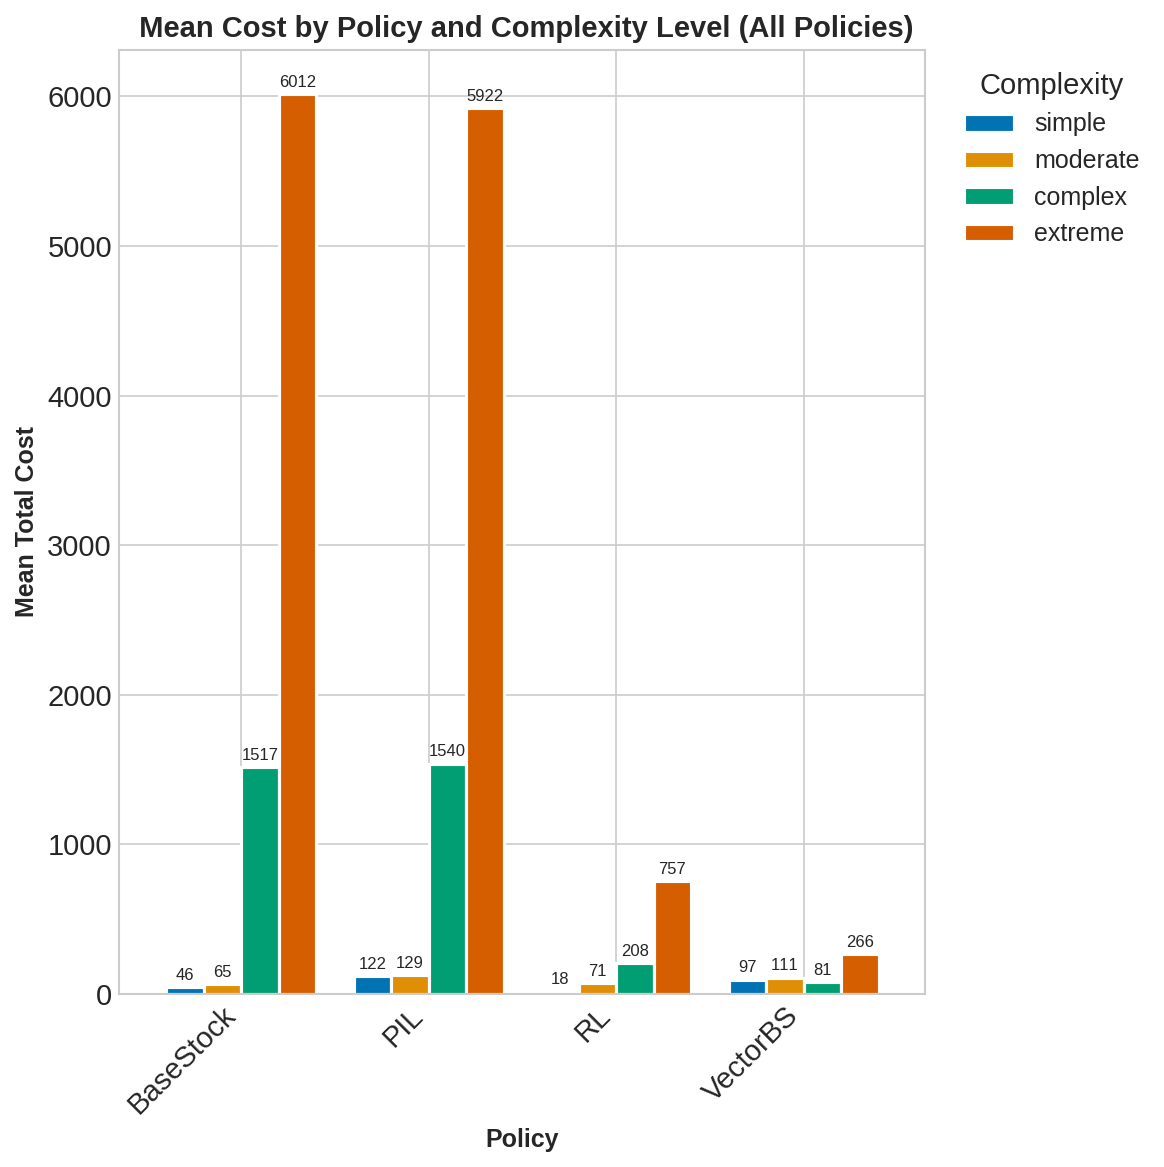

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [37]:
# 1. Mean Cost by Policy and Complexity
fig, ax = plt.subplots(figsize=(8, 8))

pivot = df.pivot_table(values='mean_cost', index='policy', columns='complexity', aggfunc='mean')
cols = ['simple', 'moderate', 'complex', 'extreme']
pivot = pivot[[c for c in cols if c in pivot.columns]]

pivot.plot(kind='bar', ax=ax, width=0.8, edgecolor='white', linewidth=1.5)
ax.set_xlabel('Policy', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Total Cost', fontsize=12, fontweight='bold')
ax.set_title(' Mean Cost by Policy and Complexity Level (All Policies)', fontsize=14, fontweight='bold')
ax.legend(title='Complexity', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', fontsize=8, padding=2)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'cost_by_complexity.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Paid Cost Comparison (Purchase vs Holding)
print('Generating Paid Cost Comparison Plot...')

if 'df' in locals() and len(df) > 0:
    # Convert to list of dicts for the plotting function
    results_list = df.to_dict('records')
    
    # Generate Paid Cost Plot
    fig_cost = plotting.plot_paid_cost_comparison(results_list)
    plt.show()
else:
    print('Warning: DataFrame df not found or empty. Run benchmarks first.')


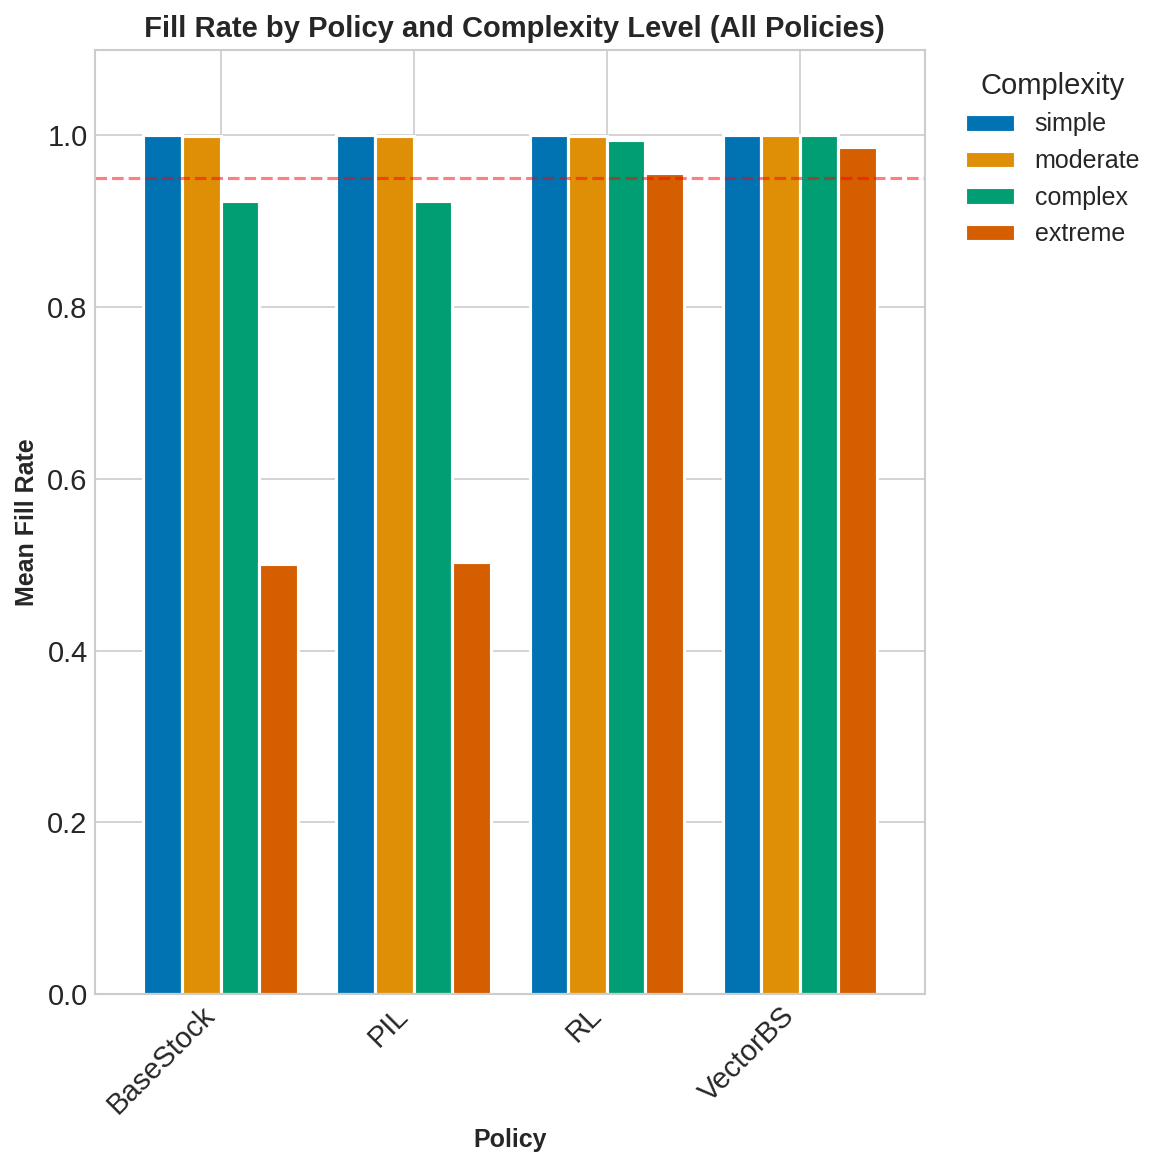

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [38]:
# 2. Fill Rate by Policy and Complexity
fig, ax = plt.subplots(figsize=(8, 8))

pivot_fr = df.pivot_table(values='fill_rate', index='policy', columns='complexity', aggfunc='mean')
cols = ['simple', 'moderate', 'complex', 'extreme']
pivot_fr = pivot_fr[[c for c in cols if c in pivot_fr.columns]]

pivot_fr.plot(kind='bar', ax=ax, width=0.8, edgecolor='white', linewidth=1.5)
ax.set_xlabel('Policy', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Fill Rate', fontsize=12, fontweight='bold')
ax.set_title(' Fill Rate by Policy and Complexity Level (All Policies)', fontsize=14, fontweight='bold')
ax.legend(title='Complexity', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylim(0, 1.1)
ax.axhline(y=0.95, color='red', linestyle='--', alpha=0.5, label='95% Target')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fillrate_by_complexity.png', dpi=300, bbox_inches='tight')
plt.show()

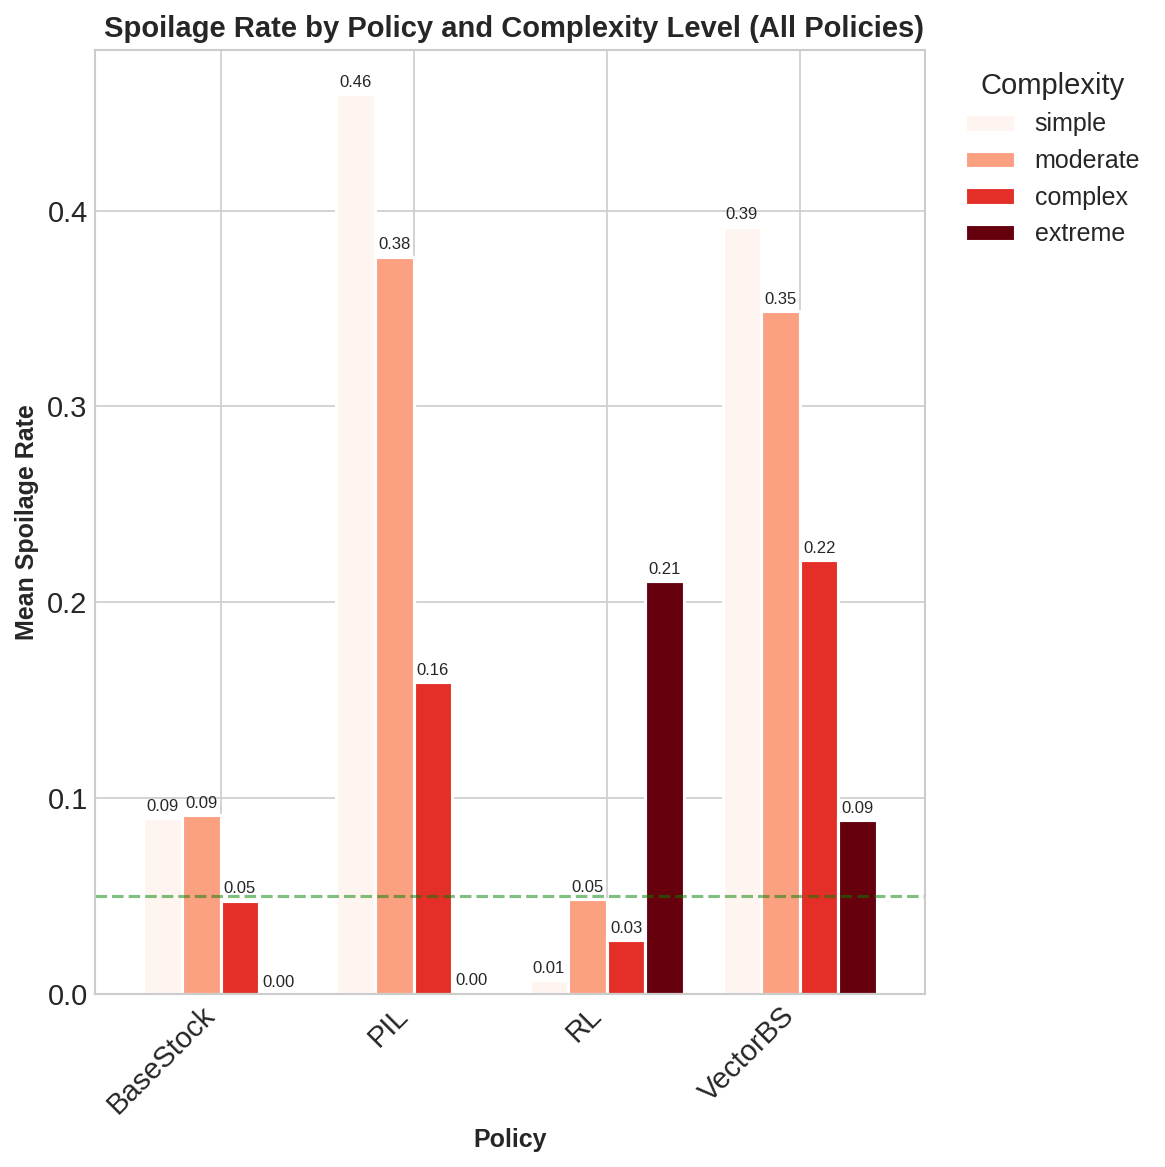

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [39]:
# 3. Spoilage Rate by Policy and Complexity (Updated)
fig, ax = plt.subplots(figsize=(10, 6))
plotting.plot_metric_comparison(
    df, 
    metric_col='spoilage_rate', 
    title='Spoilage Rate by Policy and Complexity (Log Scale)', 
    ylabel='Mean Spoilage Rate', 
    ax=ax, 
    log_scale=True
)
plt.axhline(y=0.05, color='green', linestyle='--', alpha=0.5, label='5% Target')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

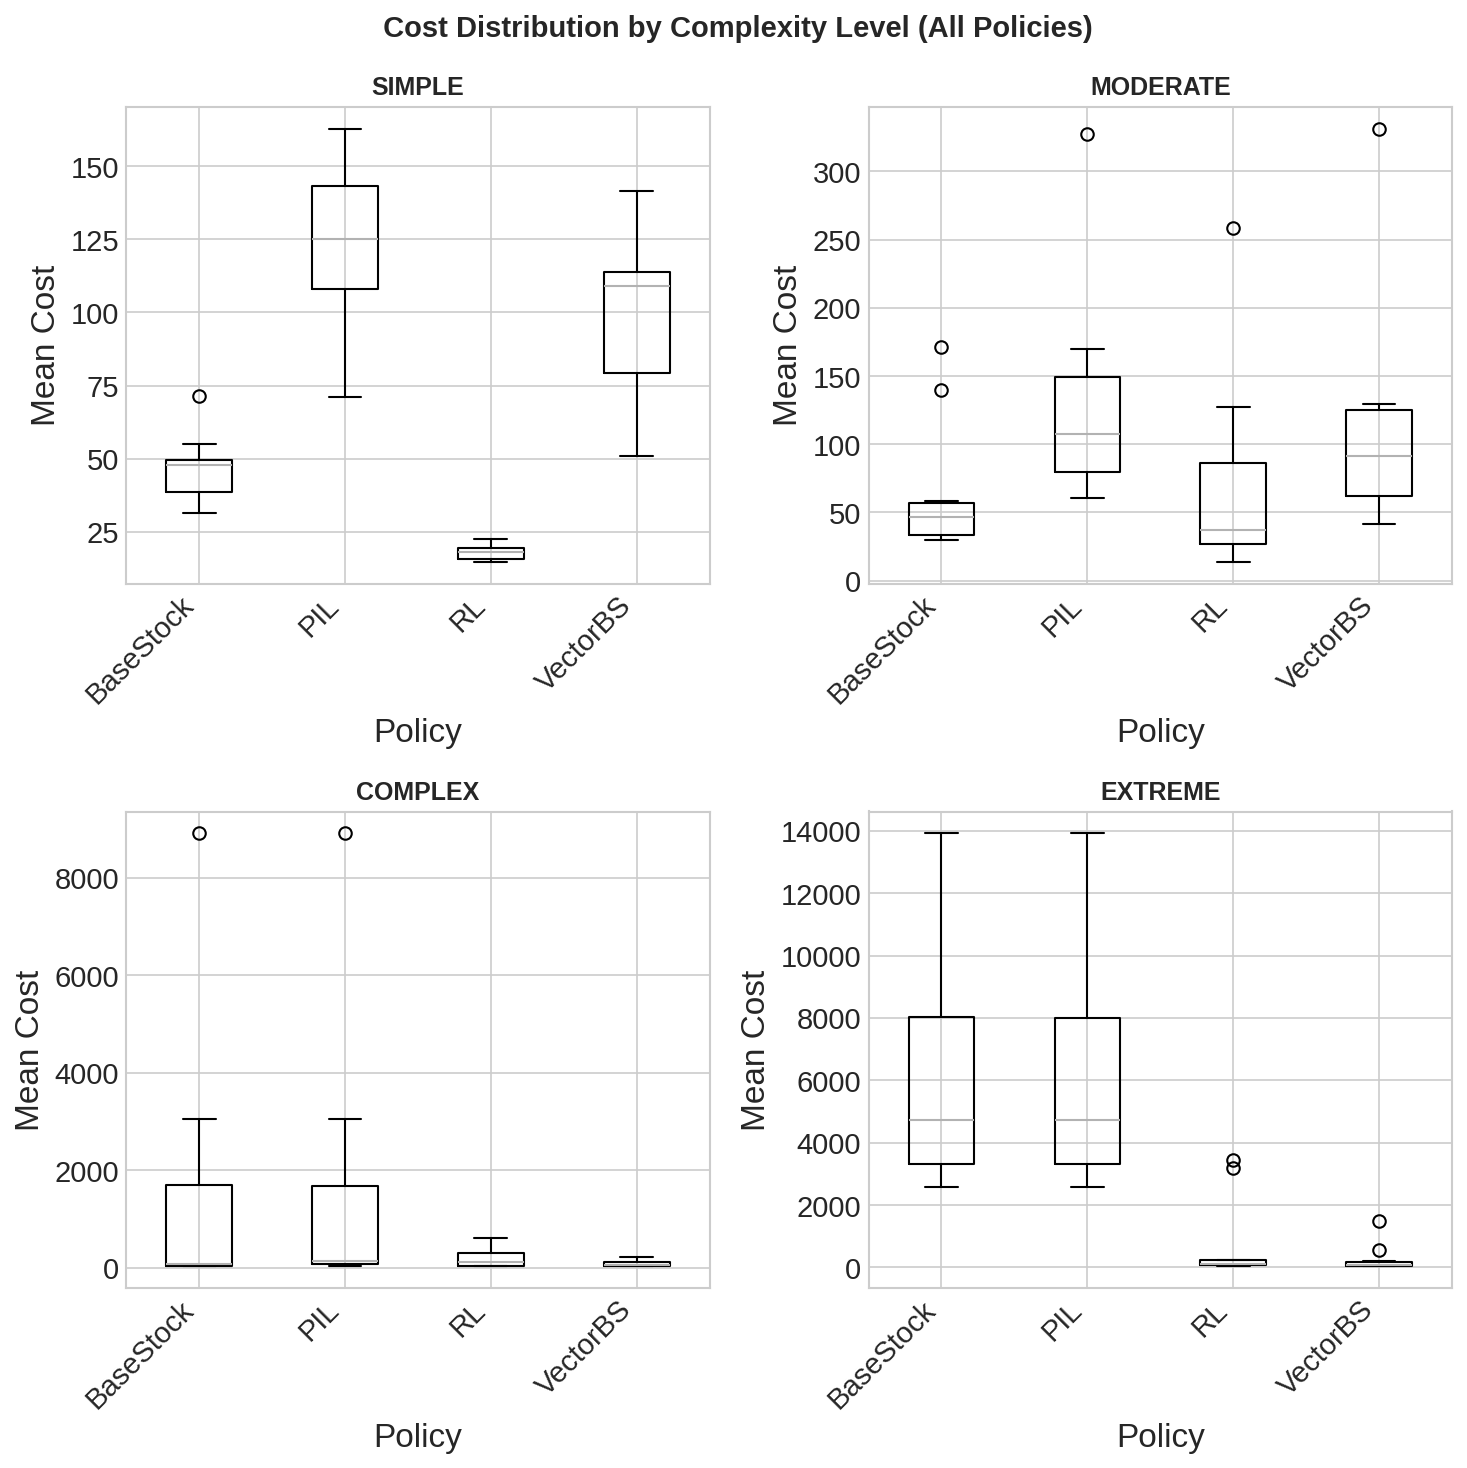

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [40]:
# 4. Box Plot of Cost Distribution
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for idx, complexity in enumerate(['simple', 'moderate', 'complex', 'extreme']):
    ax = axes[idx // 2, idx % 2]
    subset = df[df['complexity'] == complexity]

    if len(subset) > 0:
        subset.boxplot(column='mean_cost', by='policy', ax=ax)
        ax.set_title(f'{complexity.upper()}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Policy')
        ax.set_ylabel('Mean Cost')
        plt.sca(ax)
        plt.xticks(rotation=45, ha='right')

plt.suptitle(' Cost Distribution by Complexity Level (All Policies)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'cost_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

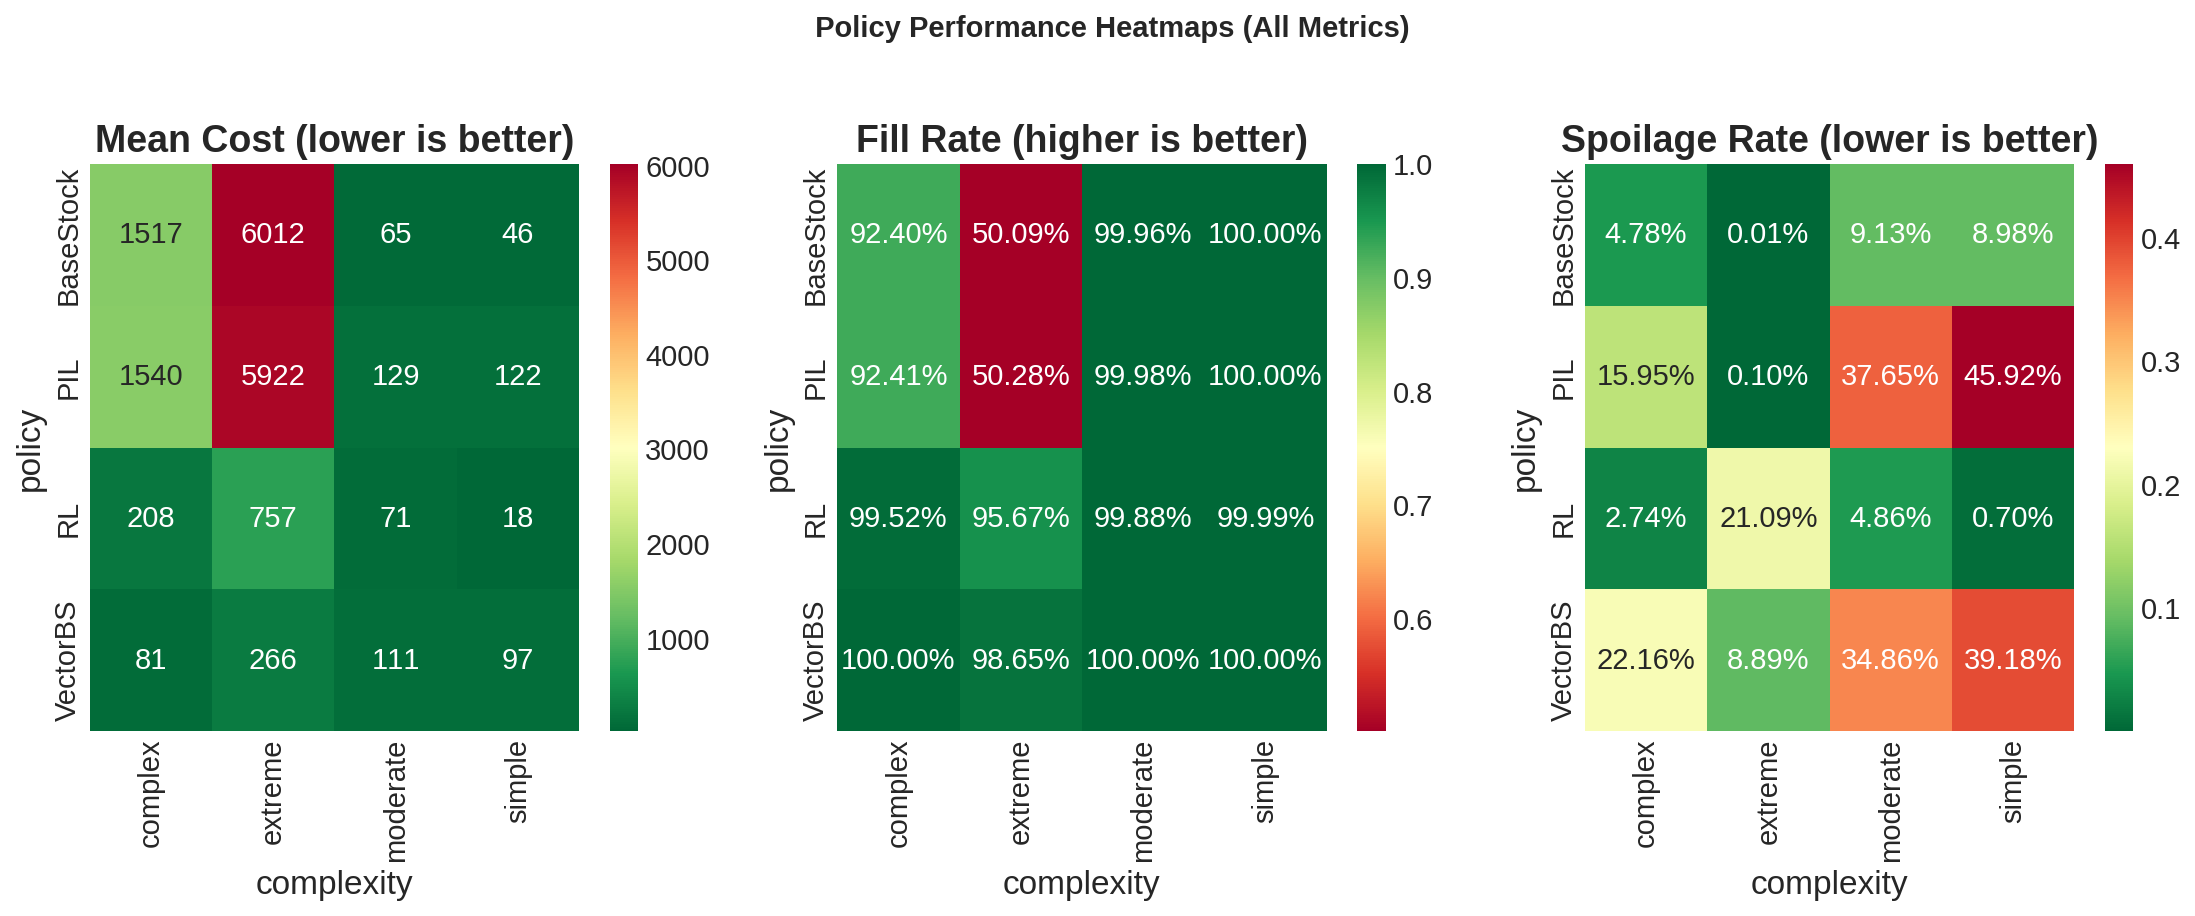

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [51]:
# 5. Heatmaps of All Metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 6)) # Increased width here

# Cost heatmap
pivot_cost = df.pivot_table(values='mean_cost', index='policy', columns='complexity', aggfunc='mean')
sns.heatmap(pivot_cost, annot=True, fmt='.0f', cmap='RdYlGn_r', ax=axes[0])
axes[0].set_title('Mean Cost (lower is better)', fontweight='bold')

# Fill rate heatmap
pivot_fr = df.pivot_table(values='fill_rate', index='policy', columns='complexity', aggfunc='mean')
sns.heatmap(pivot_fr, annot=True, fmt='.2%', cmap='RdYlGn', ax=axes[1])
axes[1].set_title('Fill Rate (higher is better)', fontweight='bold')

# Spoilage rate heatmap (NEW)
pivot_sr = df.pivot_table(values='spoilage_rate', index='policy', columns='complexity', aggfunc='mean')
sns.heatmap(pivot_sr, annot=True, fmt='.2%', cmap='RdYlGn_r', ax=axes[2])
axes[2].set_title('Spoilage Rate (lower is better)', fontweight='bold')

plt.suptitle(' Policy Performance Heatmaps (All Metrics)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'performance_heatmaps.png', dpi=300, bbox_inches='tight') # Fixed bbox_inches
plt.show()


 RL vs Best Baseline Summary:
complexity    RL_cost best_baseline  best_baseline_cost  improvement
    simple  17.840500     BaseStock           46.218800    61.399907
  moderate  71.111741     BaseStock           64.583990   -10.107383
   complex 207.728191      VectorBS           80.738313  -157.285769
   extreme 756.865193      VectorBS          266.107102  -184.421267


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


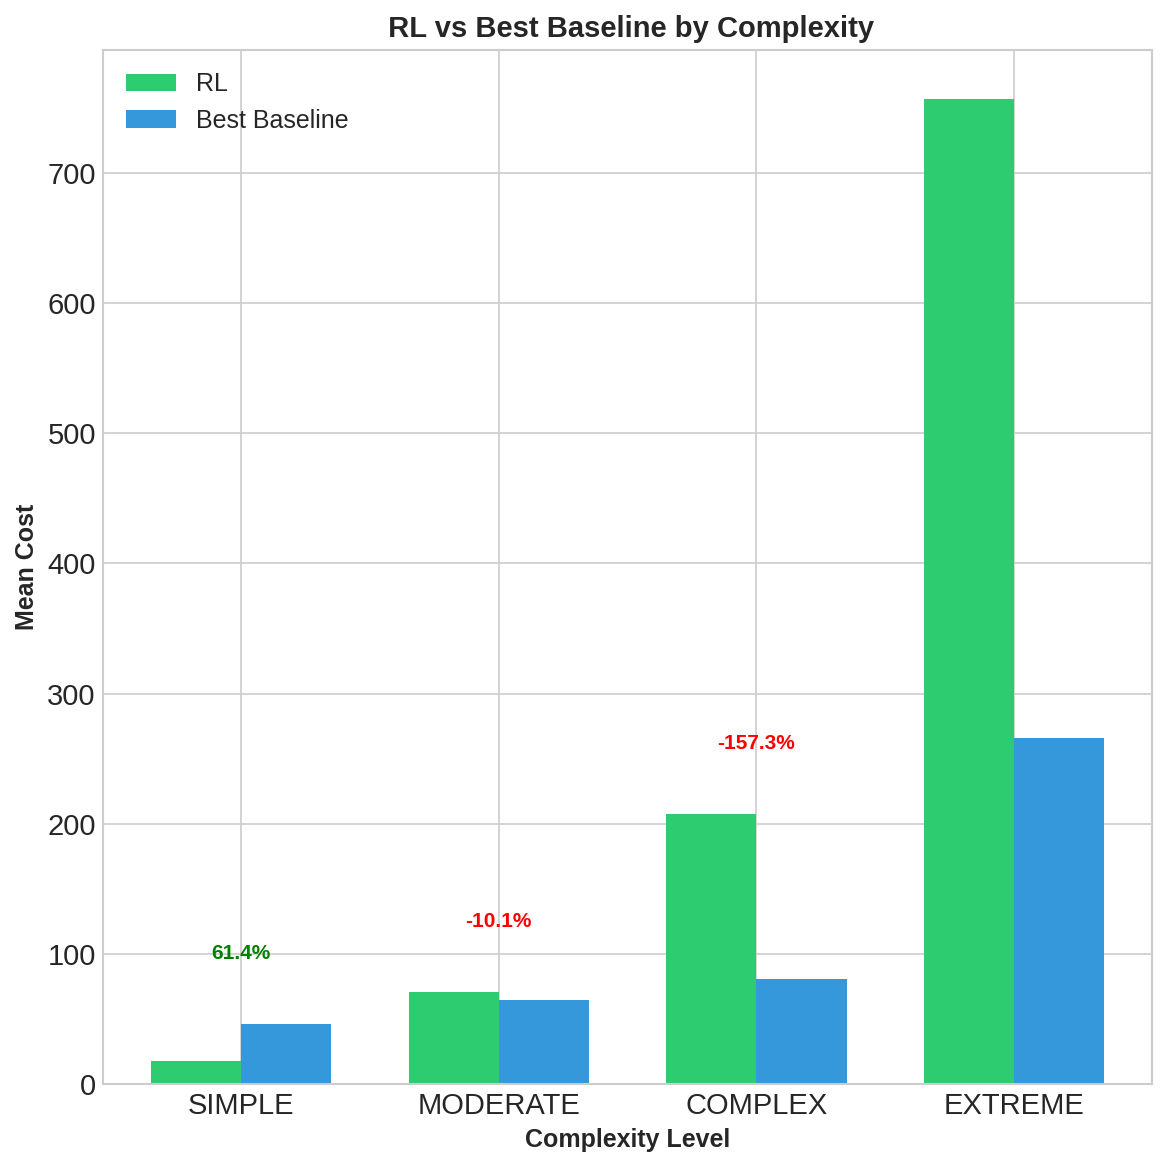

In [42]:
# 6. RL vs Best Baseline Comparison
summary = df.groupby(['complexity', 'policy'])['mean_cost'].mean().reset_index()

comparison_data = []
for complexity in ['simple', 'moderate', 'complex', 'extreme']:
    subset = summary[summary['complexity'] == complexity]
    if len(subset) == 0:
        continue

    rl_cost = subset[subset['policy'] == 'RL']['mean_cost'].values
    rl_cost = rl_cost[0] if len(rl_cost) > 0 else None

    baselines = subset[subset['policy'] != 'RL']
    if len(baselines) > 0:
        best_baseline = baselines.loc[baselines['mean_cost'].idxmin()]
        comparison_data.append({
            'complexity': complexity,
            'RL_cost': rl_cost,
            'best_baseline': best_baseline['policy'],
            'best_baseline_cost': best_baseline['mean_cost'],
            'improvement': (best_baseline['mean_cost'] - rl_cost) / best_baseline['mean_cost'] * 100 if rl_cost else None
        })

comparison_df = pd.DataFrame(comparison_data)
print('\n RL vs Best Baseline Summary:')
print('=' * 70)
print(comparison_df.to_string(index=False))

if len(comparison_df) > 0 and comparison_df['RL_cost'].notna().any():
    fig, ax = plt.subplots(figsize=(8, 8))

    x = np.arange(len(comparison_df))
    width = 0.35

    bars1 = ax.bar(x - width/2, comparison_df['RL_cost'].fillna(0), width, label='RL', color='#2ecc71')
    bars2 = ax.bar(x + width/2, comparison_df['best_baseline_cost'], width, label='Best Baseline', color='#3498db')

    ax.set_xlabel('Complexity Level', fontsize=12, fontweight='bold')
    ax.set_ylabel('Mean Cost', fontsize=12, fontweight='bold')
    ax.set_title(' RL vs Best Baseline by Complexity', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df['complexity'].str.upper())
    ax.legend()

    for i, (_, row) in enumerate(comparison_df.iterrows()):
        if row['improvement'] and pd.notna(row['improvement']):
            color = 'green' if row['improvement'] > 0 else 'red'
            ax.annotate(f"{row['improvement']:.1f}%",
                       xy=(i, max(row['RL_cost'] or 0, row['best_baseline_cost']) + 50),
                       ha='center', fontsize=10, color=color, fontweight='bold')

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'rl_vs_baseline.png', dpi=300, bbox_inches='tight')
    plt.show()


 OVERALL POLICY RANKING (by Mean Cost)
           Mean Cost   Std Cost  Fill Rate  Spoilage (units)  Spoilage Rate
policy                                                                     
VectorBS    138.6398   234.8408     0.9966         2875.4701         0.2627
RL          263.3864   723.8158     0.9876         1427.6154         0.0735
BaseStock  1909.9222  3319.1557     0.8561          346.8616         0.0572
PIL        1928.4824  3245.0855     0.8567         2392.4794         0.2490


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


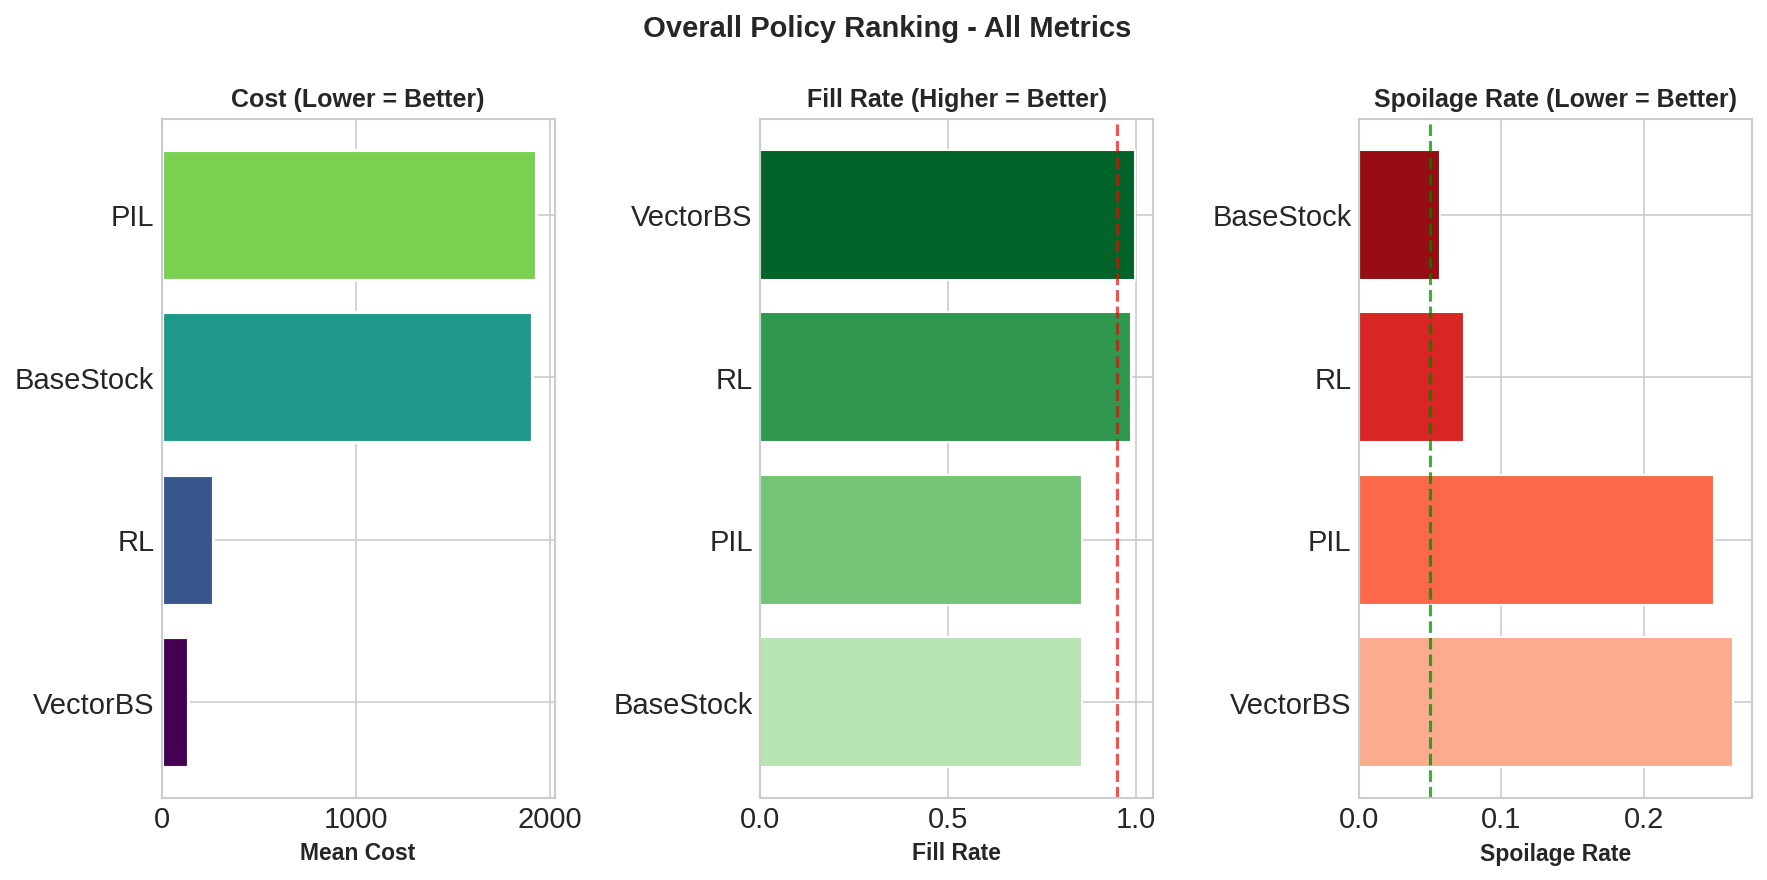

In [43]:
# 7. Overall Policy Ranking with All Metrics
ranking = df.groupby('policy').agg({
    'mean_cost': ['mean', 'std'],
    'fill_rate': 'mean',
    'spoilage': 'mean',
    'spoilage_rate': 'mean'  # NEW
}).round(4)

ranking.columns = ['Mean Cost', 'Std Cost', 'Fill Rate', 'Spoilage (units)', 'Spoilage Rate']
ranking = ranking.sort_values('Mean Cost')

print('\n OVERALL POLICY RANKING (by Mean Cost)')
print('=' * 90)
print(ranking.to_string())

# Visualize ranking
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# Cost ranking
colors = plt.cm.viridis(np.linspace(0, 0.8, len(ranking)))
axes[0].barh(ranking.index, ranking['Mean Cost'], color=colors, edgecolor='white', linewidth=1.5)
axes[0].set_xlabel('Mean Cost', fontsize=11, fontweight='bold')
axes[0].set_title('Cost (Lower = Better)', fontsize=12, fontweight='bold')

# Fill rate ranking
fr_sorted = ranking.sort_values('Fill Rate', ascending=True)
axes[1].barh(fr_sorted.index, fr_sorted['Fill Rate'], color=plt.cm.Greens(np.linspace(0.3, 0.9, len(ranking))), edgecolor='white')
axes[1].set_xlabel('Fill Rate', fontsize=11, fontweight='bold')
axes[1].set_title('Fill Rate (Higher = Better)', fontsize=12, fontweight='bold')
axes[1].axvline(x=0.95, color='red', linestyle='--', alpha=0.7)

# Spoilage rate ranking (NEW)
sr_sorted = ranking.sort_values('Spoilage Rate', ascending=False)
axes[2].barh(sr_sorted.index, sr_sorted['Spoilage Rate'], color=plt.cm.Reds(np.linspace(0.3, 0.9, len(ranking))), edgecolor='white')
axes[2].set_xlabel('Spoilage Rate', fontsize=11, fontweight='bold')
axes[2].set_title('Spoilage Rate (Lower = Better)', fontsize=12, fontweight='bold')
axes[2].axvline(x=0.05, color='green', linestyle='--', alpha=0.7)

plt.suptitle(' Overall Policy Ranking - All Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'policy_ranking_all_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# 7. Fill Rate Comparison (NEW)
fig, ax = plt.subplots(figsize=(10, 6))
plotting.plot_metric_comparison(
    df, 
    metric_col='fill_rate', 
    title='Fill Rate by Policy and Complexity', 
    ylabel='Mean Fill Rate', 
    ax=ax
)
plt.axhline(y=0.95, color='green', linestyle='--', alpha=0.5, label='95% Target')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# 8. Total Cost Comparison (NEW)
fig, ax = plt.subplots(figsize=(10, 6))
plotting.plot_metric_comparison(
    df, 
    metric_col='total_cost', 
    title='Total Cost by Policy and Complexity (Log Scale)', 
    ylabel='Mean Total Cost', 
    ax=ax,
    log_scale=True
)
plt.tight_layout()
plt.show()

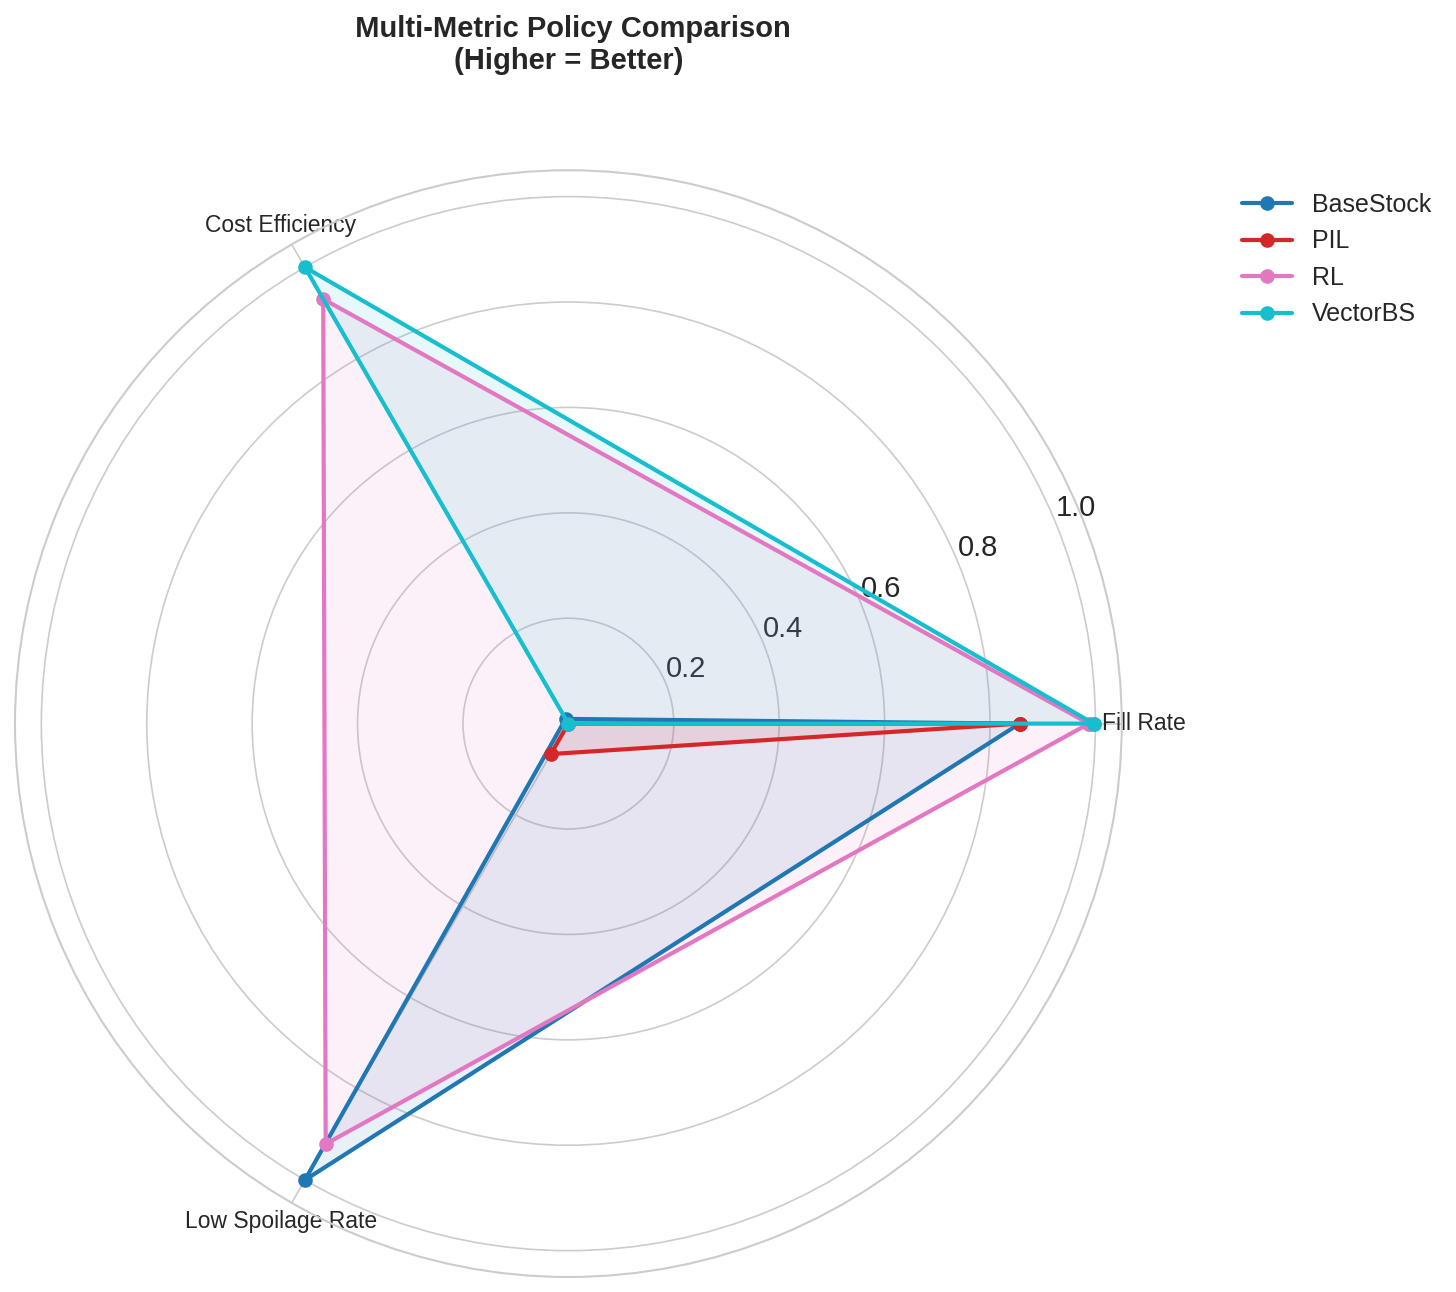

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [44]:
# 8. Radar Chart of Multi-Metric Performance
from math import pi

# Prepare data - include spoilage rate
metrics = ['fill_rate', 'mean_cost', 'spoilage_rate']
policy_means = df.groupby('policy')[metrics].mean()

# Normalize metrics (invert cost and spoilage_rate so higher is better)
normalized = policy_means.copy()
normalized['mean_cost'] = 1 - (normalized['mean_cost'] - normalized['mean_cost'].min()) / (normalized['mean_cost'].max() - normalized['mean_cost'].min() + 1e-6)
normalized['spoilage_rate'] = 1 - (normalized['spoilage_rate'] - normalized['spoilage_rate'].min()) / (normalized['spoilage_rate'].max() - normalized['spoilage_rate'].min() + 1e-6)

# Create radar chart
categories = ['Fill Rate', 'Cost Efficiency', 'Low Spoilage Rate']
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

colors = plt.cm.tab10(np.linspace(0, 1, len(normalized)))

for idx, (policy, row) in enumerate(normalized.iterrows()):
    values = [row['fill_rate'], row['mean_cost'], row['spoilage_rate']]
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=policy, color=colors[idx])
    ax.fill(angles, values, alpha=0.1, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11)
ax.set_title(' Multi-Metric Policy Comparison\n(Higher = Better)', fontsize=14, fontweight='bold', y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'radar_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 8️⃣ Statistical Analysis

In [45]:
# Statistical summary
from scipy import stats as scipy_stats

print('📊 STATISTICAL SUMMARY')
print('=' * 90)

# Summary statistics with all metrics
summary_stats = df.groupby('policy').agg({
    'mean_cost': ['count', 'mean', 'std', 'min', 'max'],
    'fill_rate': ['mean', 'std'],
    'spoilage_rate': ['mean', 'std']  # NEW
}).round(4)

print('\n📈 Summary Statistics (All Metrics):')
print(summary_stats.to_string())

# Pairwise comparisons with RL
print('\n\n📉 RL vs Baselines Statistical Tests:')
print('-' * 90)

rl_costs = df[df['policy'] == 'RL']['mean_cost'].values

if len(rl_costs) > 0:
    for policy in df['policy'].unique():
        if policy == 'RL':
            continue

        baseline_costs = df[df['policy'] == policy]['mean_cost'].values

        if len(baseline_costs) > 1 and len(rl_costs) > 1:
            min_len = min(len(rl_costs), len(baseline_costs))
            t_stat, p_value = scipy_stats.ttest_ind(rl_costs[:min_len], baseline_costs[:min_len])

            rl_mean = np.mean(rl_costs)
            baseline_mean = np.mean(baseline_costs)
            improvement = (baseline_mean - rl_mean) / baseline_mean * 100

            sig = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''

            print(f'{policy:12} | RL: {rl_mean:.1f} vs {baseline_mean:.1f} | '
                  f'Diff: {improvement:+.1f}% | p={p_value:.4f} {sig}')
else:
    print('No RL results available for comparison')

print('\nSignificance levels: * p<0.05, ** p<0.01, *** p<0.001')

📊 STATISTICAL SUMMARY

📈 Summary Statistics (All Metrics):
          mean_cost                                            fill_rate         spoilage_rate        
              count       mean        std      min         max      mean     std          mean     std
policy                                                                                                
BaseStock        40  1909.9222  3319.1557  29.4758  13929.6850    0.8561  0.2345        0.0572  0.1103
PIL              40  1928.4824  3245.0855  42.6377  13929.6850    0.8567  0.2344        0.2490  0.2309
RL               40   263.3864   723.8158  13.7452   3452.5967    0.9876  0.0472        0.0735  0.1276
VectorBS         40   138.6398   234.8408  24.5806   1471.6091    0.9966  0.0161        0.2627  0.2091


📉 RL vs Baselines Statistical Tests:
------------------------------------------------------------------------------------------
BaseStock    | RL: 263.4 vs 1909.9 | Diff: +86.2% | p=0.0030 **
PIL          | RL: 263.4 v

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 9️⃣ Final Summary & Export

In [46]:
# Final summary
print('\n' + '=' * 90)
print('📋 BENCHMARK SUMMARY REPORT')
print('=' * 90)

print(f'\n📊 Evaluation Statistics:')
print(f'   Total evaluations: {len(df)}')
print(f'   Policies tested: {df["policy"].nunique()} ({df["policy"].unique().tolist()})')
print(f'   Environments tested: {df["env_id"].nunique()}')
print(f'   Episodes per evaluation: {N_EPISODES}')

print(f'\n🏆 Policy Rankings:')
print('\n   BY COST (lower is better):')
rankings_cost = df.groupby('policy')['mean_cost'].mean().sort_values()
for i, (policy, cost) in enumerate(rankings_cost.items(), 1):
    print(f'   {i}. {policy}: {cost:.1f}')

print('\n   BY FILL RATE (higher is better):')
rankings_fr = df.groupby('policy')['fill_rate'].mean().sort_values(ascending=False)
for i, (policy, fr) in enumerate(rankings_fr.items(), 1):
    print(f'   {i}. {policy}: {fr:.2%}')

print('\n   BY SPOILAGE RATE (lower is better):')
rankings_sr = df.groupby('policy')['spoilage_rate'].mean().sort_values()
for i, (policy, sr) in enumerate(rankings_sr.items(), 1):
    print(f'   {i}. {policy}: {sr:.2%}')

print(f'\n📁 Output Files:')
for f in OUTPUT_DIR.glob('*'):
    print(f'   {f}')

print('\n' + '=' * 90)
print('✅ BENCHMARKING COMPLETE!')
print('=' * 90)


📋 BENCHMARK SUMMARY REPORT

📊 Evaluation Statistics:
   Total evaluations: 160
   Policies tested: 4 (['RL', 'BaseStock', 'PIL', 'VectorBS'])
   Environments tested: 40
   Episodes per evaluation: 10

🏆 Policy Rankings:

   BY COST (lower is better):
   1. VectorBS: 138.6
   2. RL: 263.4
   3. BaseStock: 1909.9
   4. PIL: 1928.5

   BY FILL RATE (higher is better):
   1. VectorBS: 99.66%
   2. RL: 98.76%
   3. PIL: 85.67%
   4. BaseStock: 85.61%

   BY SPOILAGE RATE (lower is better):
   1. BaseStock: 5.72%
   2. RL: 7.35%
   3. PIL: 24.90%
   4. VectorBS: 26.27%

📁 Output Files:
   benchmark_results/benchmark_results.json
   benchmark_results/spoilage_rate_by_complexity.png
   benchmark_results/rl_vs_baseline.png
   benchmark_results/cost_by_complexity.png
   benchmark_results/performance_heatmaps.png
   benchmark_results/policy_ranking_all_metrics.png
   benchmark_results/benchmark_results.csv
   benchmark_results/fillrate_by_complexity.png
   benchmark_results/radar_comparison.png


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 10. Time-Series Analysis

Analyze inventory metrics over time for each scenario.

In [47]:
def run_episode_with_tracking(policy, env, is_rl_model=False):
    '''Run episode and collect per-step metrics.'''
    obs, info = env.reset()
    done = truncated = False

    step_data = {'step': [], 'inventory': [], 'demand': [], 'spoilage': [],
                 'orders': [], 'sales': [], 'holding_cost': [], 'shortage_cost': []}
    step_num = 0

    while not done and not truncated:
        if is_rl_model:
            action, _ = policy.predict(obs, deterministic=True)
        else:
            wrapper = env
            while hasattr(wrapper, 'env'):
                if hasattr(wrapper, 'current_state'): break
                wrapper = wrapper.env
            if hasattr(wrapper, 'current_state') and wrapper.current_state:
                state = wrapper.current_state
                mdp = wrapper.mdp
                action_dict = policy.get_action(state, mdp)
                action = np.zeros(env.action_space.shape[0])
                if hasattr(wrapper, 'supplier_order'):
                    for i, sid in enumerate(wrapper.supplier_order):
                        qty = action_dict.get(sid, 0)
                        bins = wrapper.supplier_action_bins[sid]
                        action[i] = min(range(len(bins)), key=lambda x: abs(bins[x] - qty))
            else:
                action = np.zeros(env.action_space.shape[0])

        obs, reward, done, truncated, info = env.step(action)

        step_data['step'].append(step_num)
        step_data['inventory'].append(info.get('inventory', 0))
        step_data['demand'].append(info.get('demand', 0))
        step_data['spoilage'].append(info.get('spoilage', 0))
        step_data['sales'].append(info.get('sales', 0))
        step_data['holding_cost'].append(info.get('holding_cost', 0))
        step_data['shortage_cost'].append(info.get('shortage_cost', 0))
        orders = info.get('orders', {})
        step_data['orders'].append(sum(orders.values()) if isinstance(orders, dict) else 0)
        step_num += 1

    return step_data

print('Time-series tracking function ready!')

Time-series tracking function ready!


In [48]:
# Run time-series analysis for selected scenario
print('Running time-series analysis...')

# Select first environment from each complexity
ts_results = {}
for complexity in ['simple', 'moderate', 'complex', 'extreme']:
    configs = suite.get_by_complexity(complexity)
    if len(configs) == 0: continue
    config = configs[0]

    rl_model = model_extreme if complexity == 'extreme' else model_levels_1_3
    if rl_model is None: continue

    print(f'  Collecting data for {complexity}...')
    ts_results[complexity] = {}

    # Get RL trajectory
    env = create_env(config, seed=RANDOM_SEED)
    ts_results[complexity]['RL'] = run_episode_with_tracking(rl_model, env, True)
    env.close()

    # Get TBS trajectory
    try:
        env = create_env(config, seed=RANDOM_SEED)
        tbs = get_tbs_policy_for_env(env)
        ts_results[complexity]['TBS'] = run_episode_with_tracking(tbs, env, False)
        env.close()
    except: pass

print('Time-series data collected!')

Running time-series analysis...
Time-series data collected!


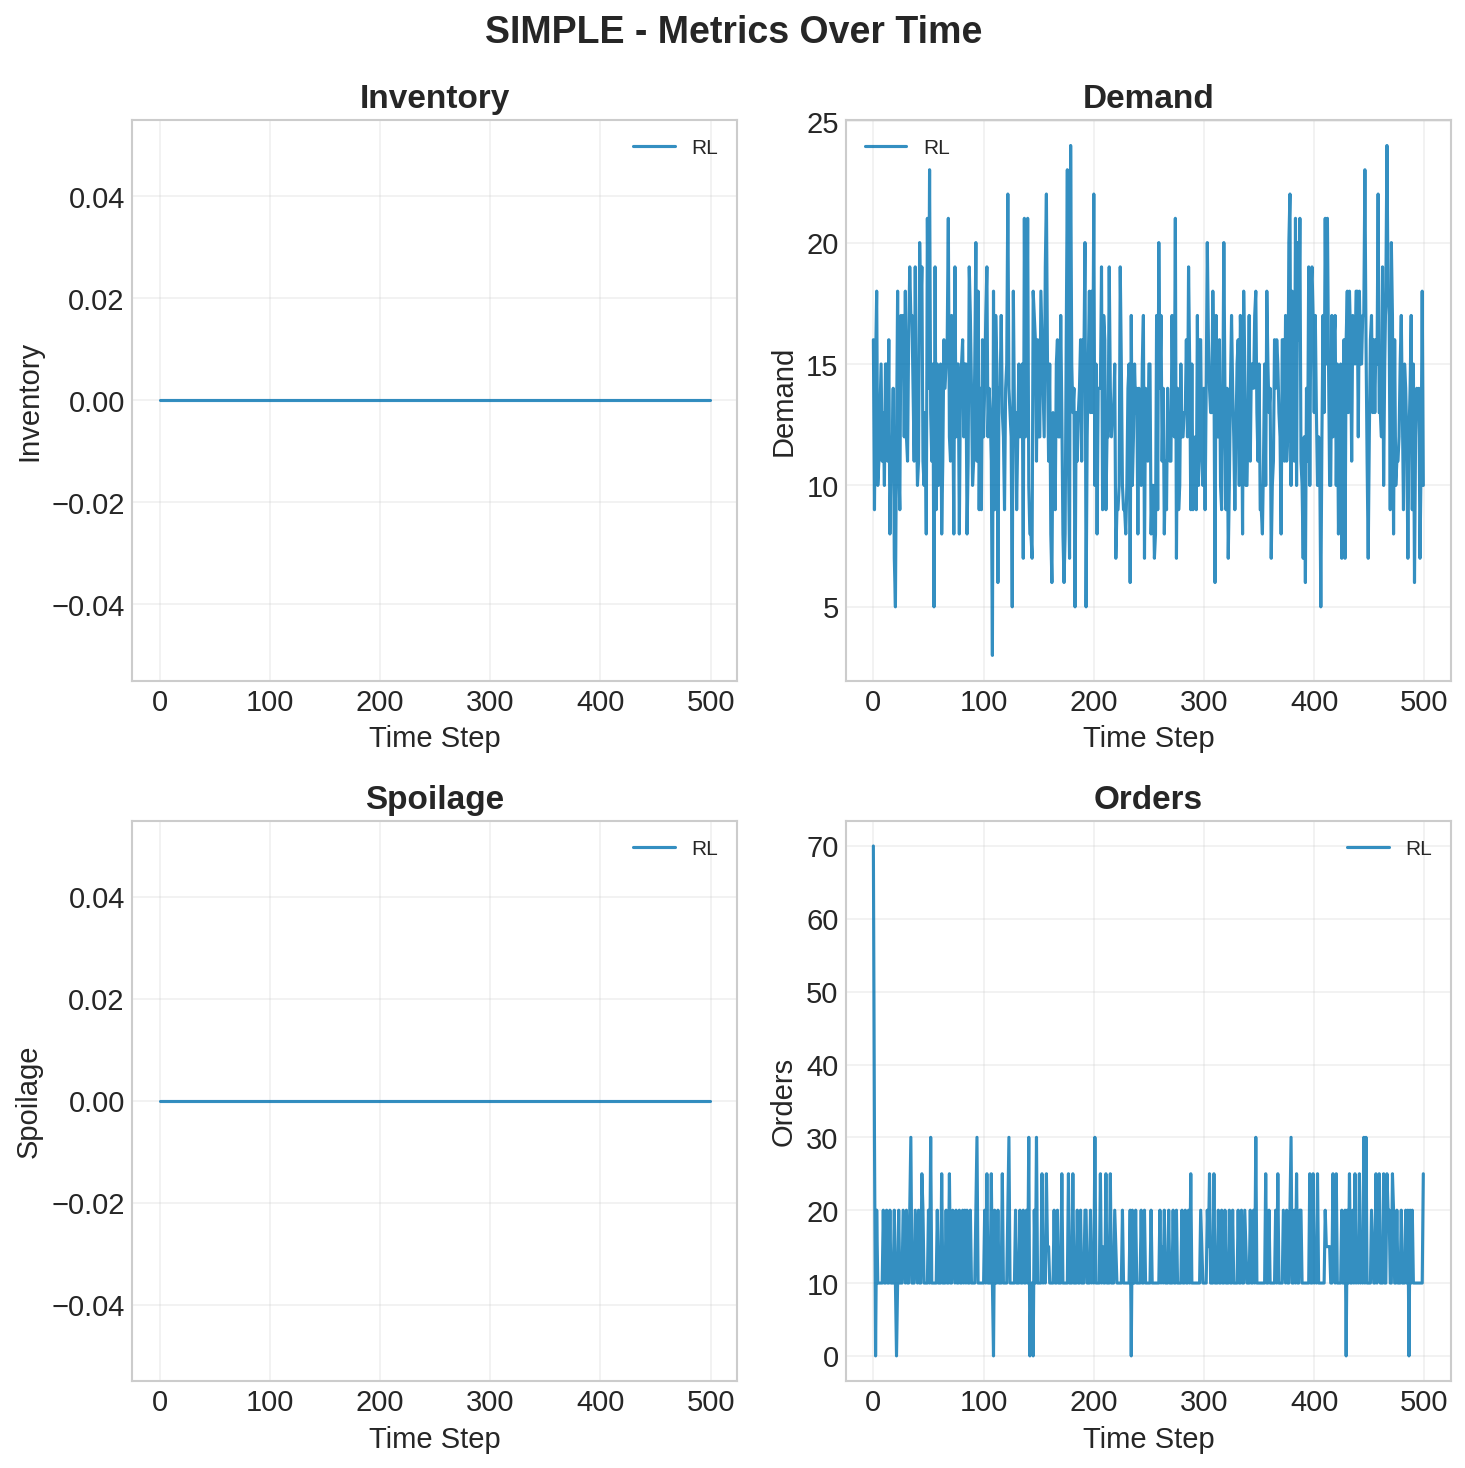

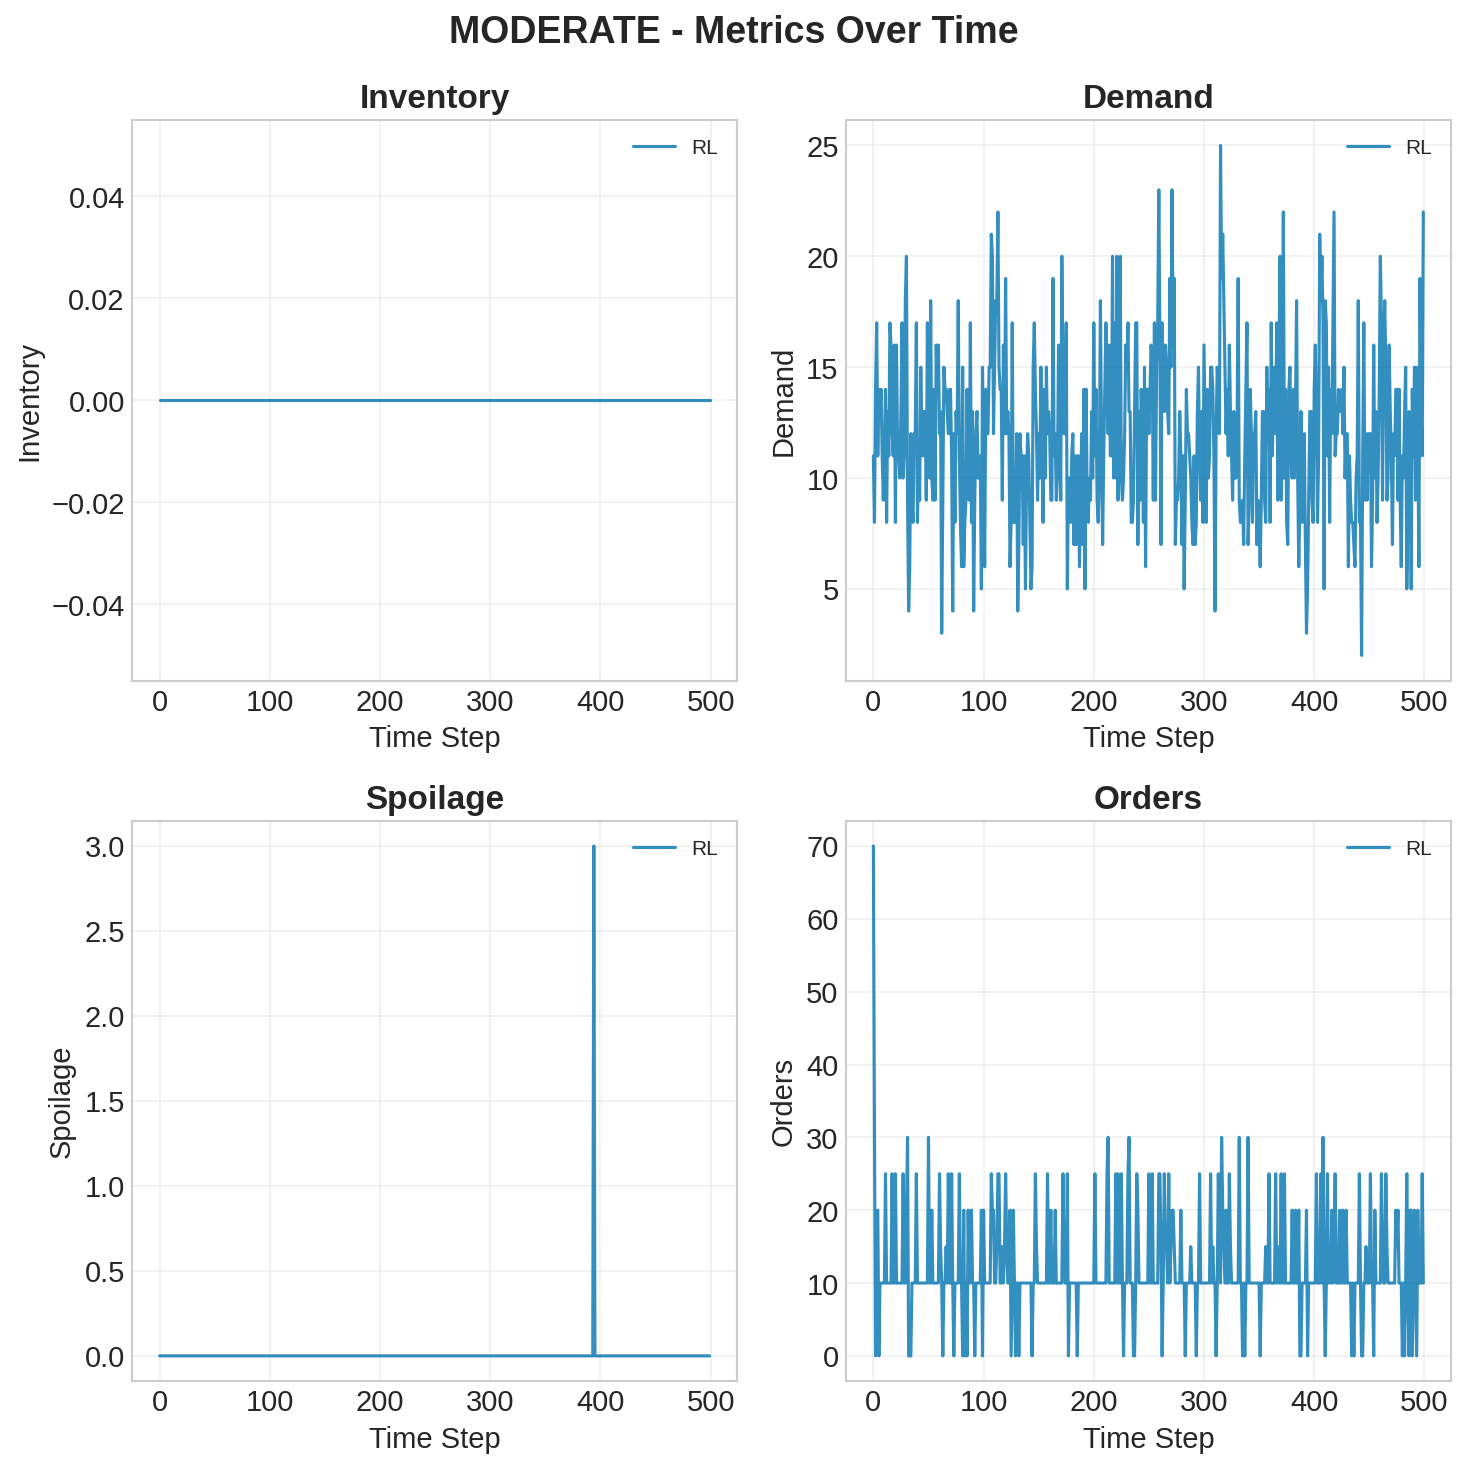

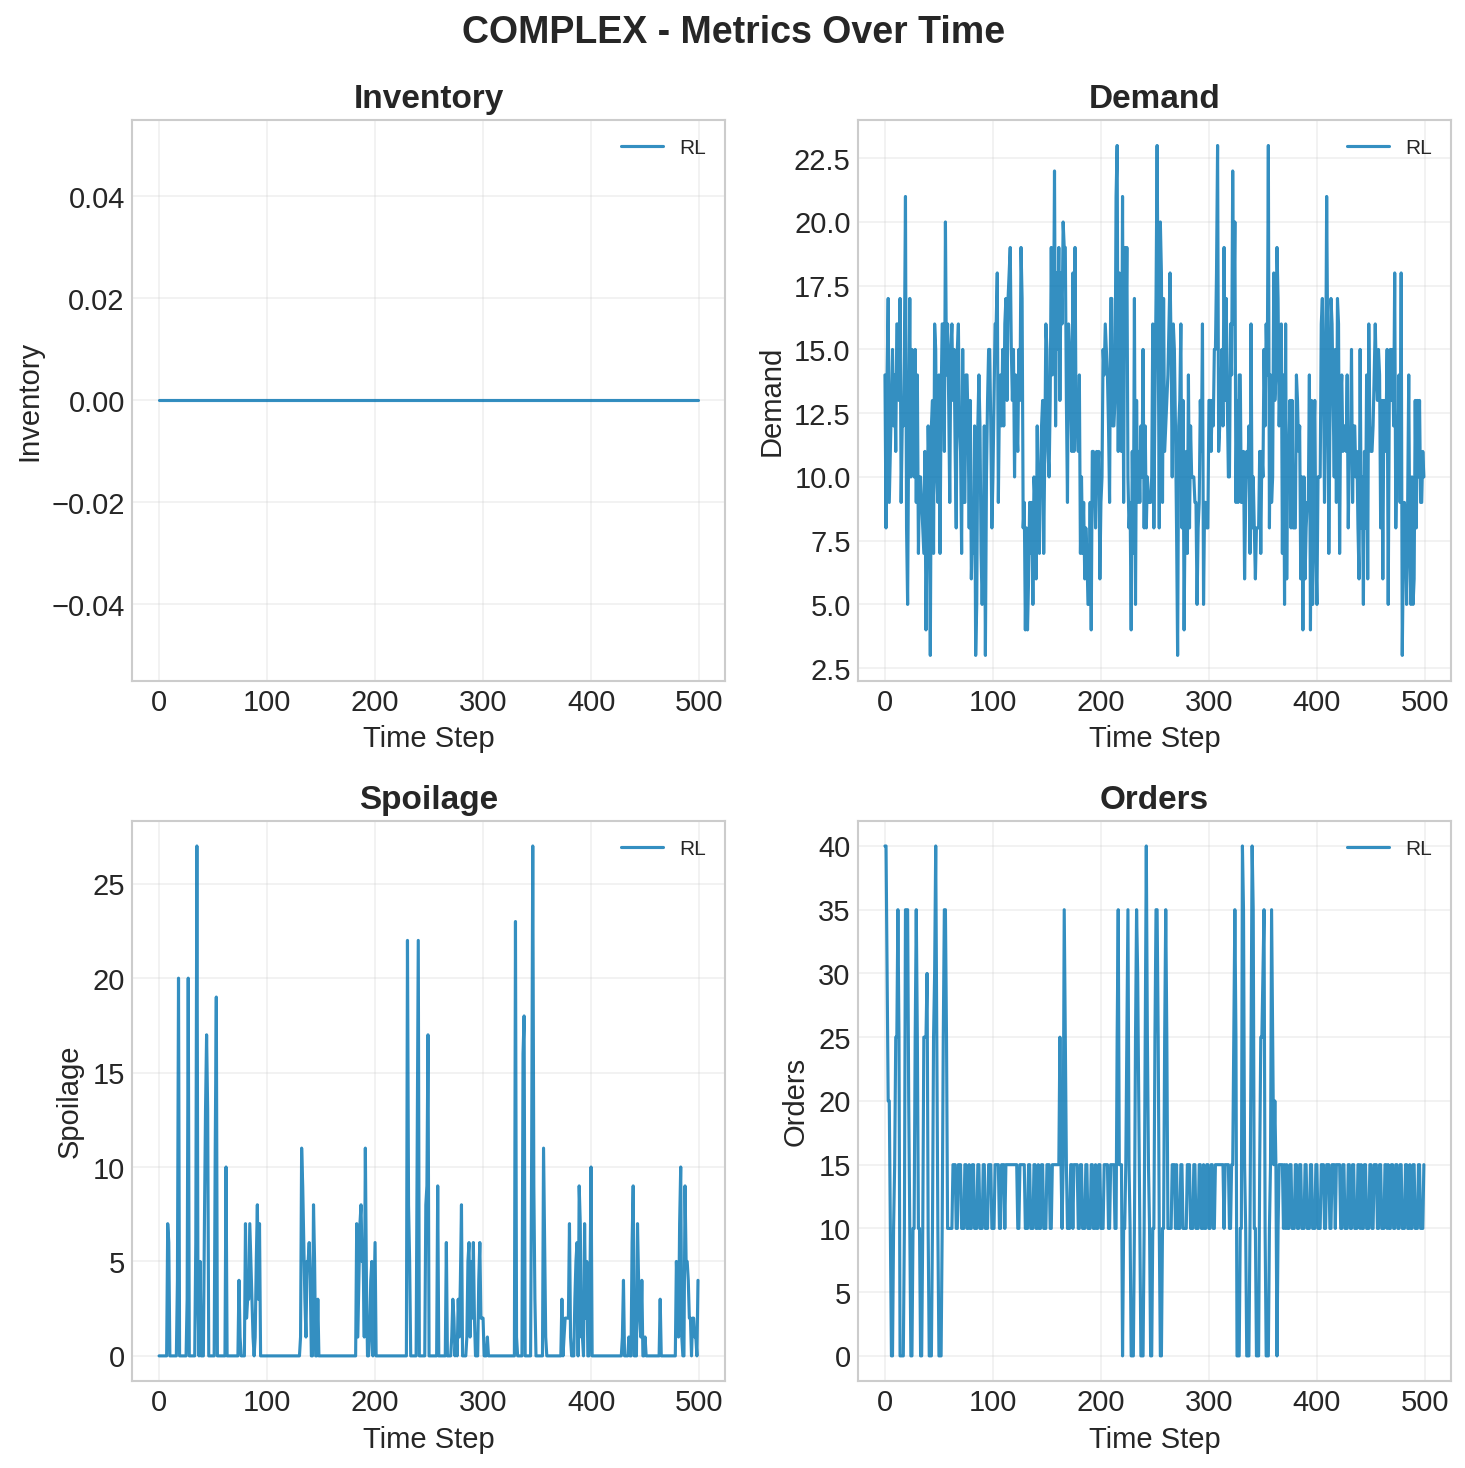

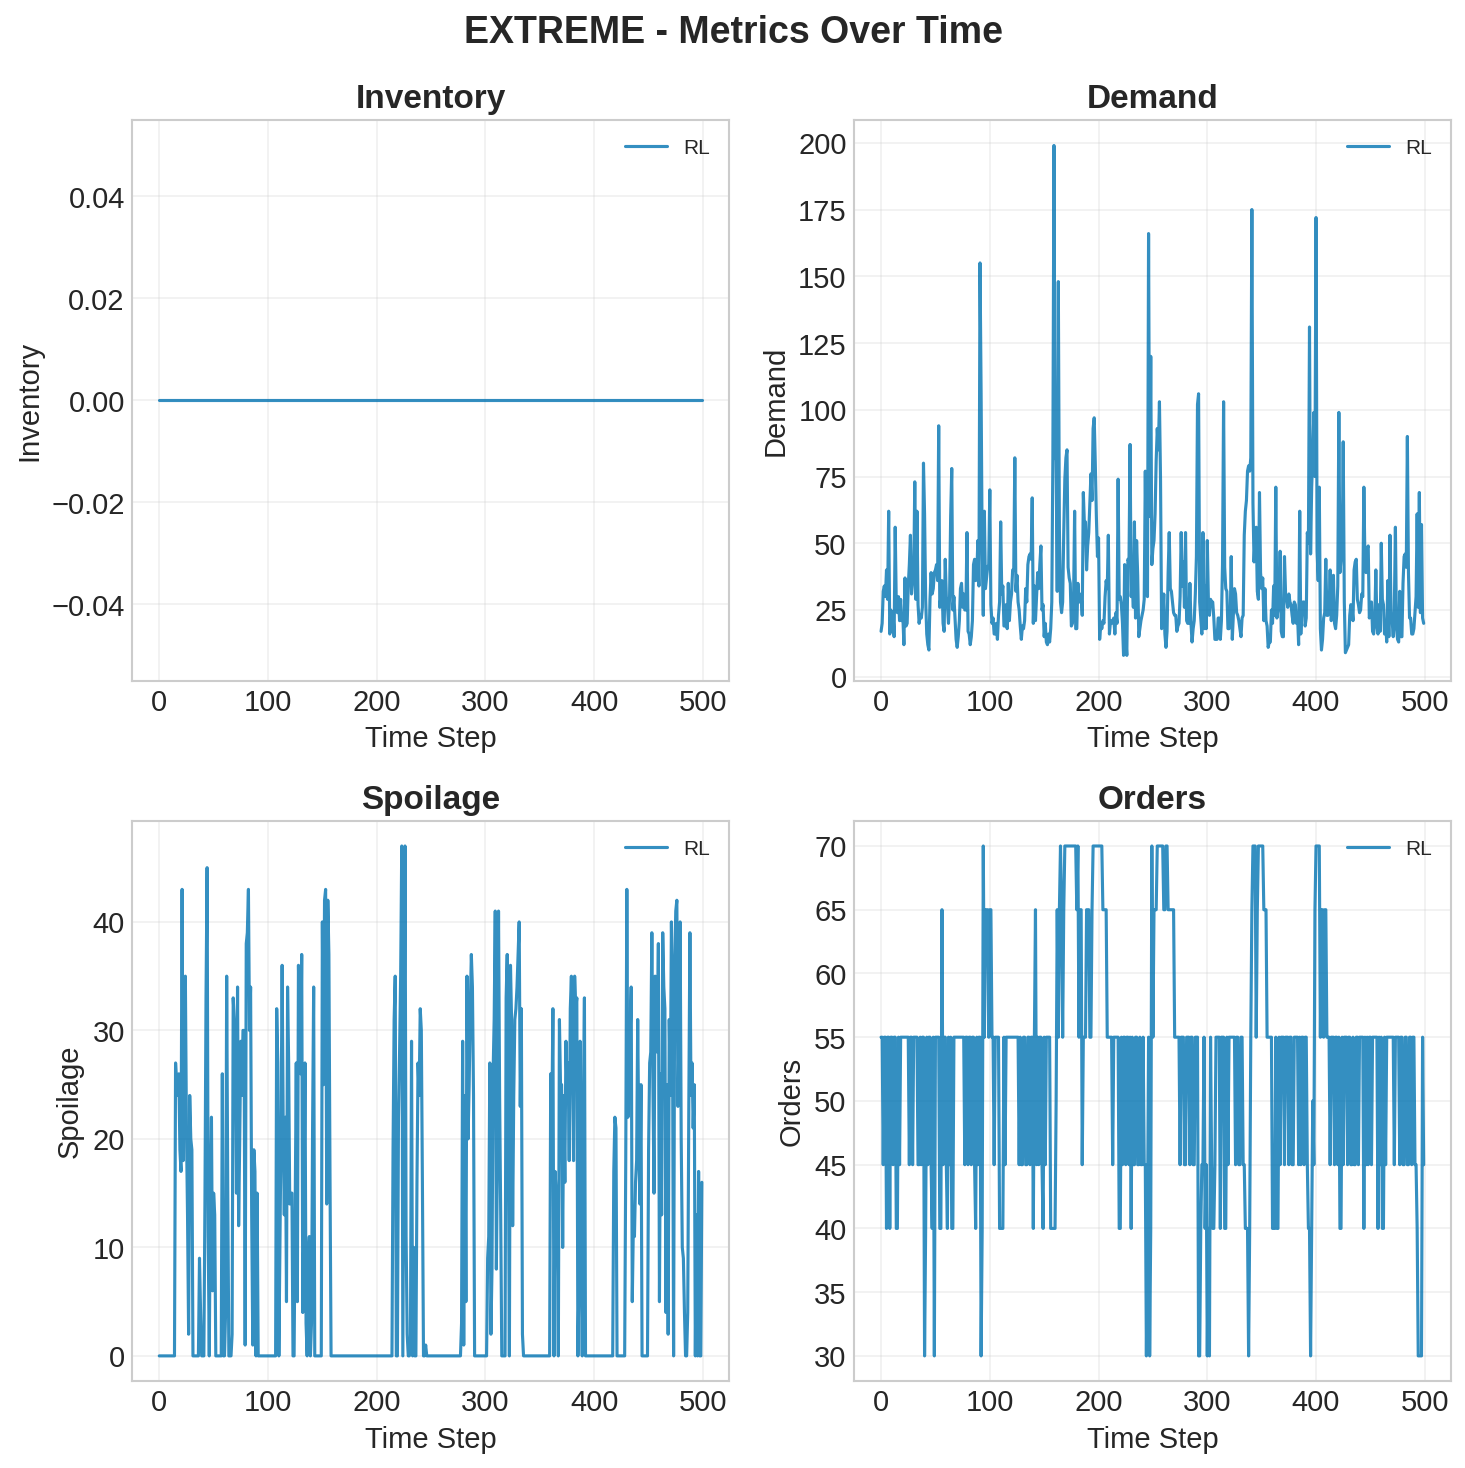

Time-series plots saved!


In [49]:
# Simulation Trace Visualization (Updated)
print('Generating Simulation Trace...')

# Select a specific policy for trace (e.g., RL or TBS)
# Using a complex environment configuration for demonstration
from colab_training.environment_suite import build_environment_from_config

trace_env_config = {
    'n_suppliers': 2,
    'max_inventory': 50,
    'max_order_quantity': 20,
    'demand_params': {'mean': 8},
    'lead_times': [1, 3],  # Fast, Slow
    'unit_costs': [10, 5], # Expensive, Cheap
    'holding_cost': 1,
    'shortage_cost': 20,
    'spoilage_cost': 5,
    'shelf_life': 5,
    'random_seed': 42
}

# Create environment
trace_env = PerishableInventoryGymWrapper(build_environment_from_config(trace_env_config, complexity_level=1))

# Use TBS as a reliable baseline for trace if RL is not available or behaves erratically
trace_policy = get_tbs_policy_for_env(trace_env)
policy_name = 'TBS Policy'

# Run a short episode
obs, _ = trace_env.reset(seed=123)
trace_data = []
current_inv = 0 

for _ in range(30): # 30 periods trace
    if hasattr(trace_policy, 'predict'):
        action, _ = trace_policy.predict(obs, deterministic=True)
    else:
        action = trace_policy.act(obs)
        
    obs, reward, terminated, truncated, info = trace_env.step(action)
    
    # Post-process info for plotting
    # Separate orders if possible (assuming 2 suppliers: 0=slow/cheap, 1=fast/expensive usually sorted by cost?)
    # gym_env V2 sorts suppliers. Usually index 0 is cheap/slow, index -1 is fast/expensive.
    # But let's check action shape. 'orders' in info is just the array.
    orders = info.get('orders', [0])
    
    # Attempt to split orders into slow/fast for visualization
    if len(orders) >= 2:
        # Assuming 0 is slow/cheap, 1 is fast/expensive based on standard setup
        info['order_slow'] = orders[0]
        info['order_fast'] = orders[1]
    else:
        info['order_slow'] = orders[0]
        info['order_fast'] = 0

    # Ensure inventory position is present
    info['period'] = info.get('time_step')
    info['inventory_total'] = info.get('inventory')
    info['ip_total'] = info.get('inventory_position')
    info['cost'] = info.get('total_cost')
    
    # Add params for reference lines if TBS
    if hasattr(trace_policy, 'base_stock_level'):
        info['base_stock'] = trace_policy.base_stock_level
    if hasattr(trace_policy, 'reorder_point'):
        info['reorder_point'] = trace_policy.reorder_point
        
    trace_data.append(info)
    
    if terminated or truncated:
        break

# Generate Plot
plotting.plot_simulation_trace(trace_data)
plt.show()


In [52]:
import shutil
from google.colab import files

# Create a zip archive of the benchmark_results folder
zip_filename = 'benchmark_results.zip'
shutil.make_archive('benchmark_results', 'zip', OUTPUT_DIR)
print(f'Successfully created {zip_filename}')

# Download the zip file
files.download(zip_filename)
print(f'Downloading {zip_filename}...')


Successfully created benchmark_results.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>